# Click-Through Rate Prediction by Jeff Gross

**Contents:**
* [Load Data](#0)
    * [Train Data](#0.1)
    * [Holdout Data](#0.2)


* [Exploratory Data Anallysis](#1)
    * [Missing Values](#1.1)
    * [Which non-integer columns to keep](#1.2)
    * [Drop Features](#1.3)
    * [Target Feature EDA](#1.4)
    * [Time Feaure](#1.5)
    * [Correlation Analysis](#1.6)


* [Pre-Procesing](#2)
    * [Converting Categorical Variables](#2.1)
        * [banner_pos](#2.1.1)
        * [site_category](#2.1.2)        
        * [app_category](#2.1.3)
        * [device_type](#2.1.4) 
        * [device_conn_type](#2.1.5)
        * [sitde_id](#2.1.6)
        * [app_id](#2.1.7)
        * [app_domain](#2.1.8)
        * [device_id](#2.1.9)
        * [device_ip](#2.1.10)
        * [device_model](#2.1.11)

* [Data Prep](#3)
    * [Split Test Data](#3.1)
    * [Scaling](#3.2)


* [Models](#4)
    * [Logistic Regression](#4.1)

    * [Decision Tree](#4.2)

    * [Random Forest Classifier](#4.3)

    * [Extreme Gradient Boosting Classifier](#4.4)


* [Results](#5)

### Imports

In [1]:
%%time

# Import winsound
import winsound

# Import pandas
import pandas as pd

# Import matplotlib.pyplot
import matplotlib.pyplot as plt
%matplotlib inline

#Import ipywidgets
from ipywidgets import interact

# Import the regular expression module
import re

#import numpy
import numpy as np

#import seaborn
import seaborn as sns

from collections import Counter
import warnings
warnings.filterwarnings('ignore')
import copy

# Import classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost.sklearn import XGBClassifier
import xgboost as xgb

# Import From Sklearn
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Imputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import FunctionTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_selection import chi2, SelectKBest
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.preprocessing import minmax_scale
from sklearn.metrics import classification_report, average_precision_score, precision_recall_fscore_support, accuracy_score 
from sklearn.metrics import roc_curve, auc, f1_score, confusion_matrix
from sklearn.model_selection import cross_val_score
from collections import Counter
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_auc_score
import scikitplot as skplt

C:\Users\Y\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Wall time: 7.26 s


<a id='0'></a>
### Load Data

Problem: This data set is big, 40,428,967 rows. It is too big to work with locally.

Solution:

Pandas comes with a few features for handling big data sets. It allows you to read big data files in chunks or you can just load the first N lines. Neither of these approaches solves the aforementioned problems, as the result is not a small randomised sample of the data. 

I have chosen to load a sample of the data using the skiprows functino of the read_csv and function (skip 1 row every 10 rows). My plan is to use it for exploratory analysis and visualisation. After having an idea of what you’re looking for, you can run your thorough analyses on a dedicated server (e.g. a VM in the cloud). It allowed me to specify a list of line/row indices, which will not be loaded by pandas. Another approach was random selection. I chose the skiprows since the data since this data set is already ordered by time of event occurrence and thus such sampling will result in a representative sample. 

The reason that I have chosen this plan is that the memory on my laptop is limited. Therefore, loading all the data in memory would make my analyses run slowly, as all operations are performed on big DataFrames. This would be disruptive to my work process.

<a id='0.1'></a>
### TRAIN DATA

In [2]:
%%time

# Load train data
f = "train.csv"

# Take every N-th (in this case 10th) row
n = 10

# Count the lines or use an upper bound
num_lines = sum(1 for l in open(f))

# The row indices to skip - make sure 0 is not included to keep the header!
skip_idx = [x for x in range(1, num_lines) if x % n != 0]

# Read the data
data = pd.read_csv(f, skiprows=skip_idx, index_col=0)

winsound.Beep(500,10000)

Wall time: 1min 45s


In [343]:
data_1 = copy.copy(data)

In [344]:
data_1.head()

,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,...,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
id,,,,,,,,,,,,,,,,,,,,,
10001264480619467364,0,14102100,1002,0,84c7ba46,c4e18dd6,50e219e0,ecad2386,7801e8d9,07d7df22,...,0,0,21689,320,50,2496,3,167,100191,23
10004482643316086592,0,14102100,1005,0,85f751fd,c4e18dd6,50e219e0,66a5f0f3,d9b5648e,cef3e649,...,1,0,21234,320,50,2434,3,163,100088,61
10005951398749600249,0,14102100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,...,1,0,15706,320,50,1722,0,35,-1,79
10007164336863914220,1,14102100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,...,1,0,15706,320,50,1722,0,35,-1,79
10009635774586344851,0,14102100,1005,0,543a539e,c7ca3108,3e814130,ecad2386,7801e8d9,07d7df22,...,1,0,20352,320,50,2333,0,39,-1,157


In [6]:
data.shape

(4042896, 23)

In [7]:
data.head()

,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,...,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
id,,,,,,,,,,,,,,,,,,,,,
10001264480619467364,0,14102100,1002,0,84c7ba46,c4e18dd6,50e219e0,ecad2386,7801e8d9,07d7df22,...,0,0,21689,320,50,2496,3,167,100191,23
10004482643316086592,0,14102100,1005,0,85f751fd,c4e18dd6,50e219e0,66a5f0f3,d9b5648e,cef3e649,...,1,0,21234,320,50,2434,3,163,100088,61
10005951398749600249,0,14102100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,...,1,0,15706,320,50,1722,0,35,-1,79
10007164336863914220,1,14102100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,...,1,0,15706,320,50,1722,0,35,-1,79
10009635774586344851,0,14102100,1005,0,543a539e,c7ca3108,3e814130,ecad2386,7801e8d9,07d7df22,...,1,0,20352,320,50,2333,0,39,-1,157


In [8]:
#list of features
data.info()

<class 'pandas.core.frame.DataFrame'>
UInt64Index: 4042896 entries, 10001264480619467364 to 9998515968748286661
Data columns (total 23 columns):
click               int64
hour                int64
C1                  int64
banner_pos          int64
site_id             object
site_domain         object
site_category       object
app_id              object
app_domain          object
app_category        object
device_id           object
device_ip           object
device_model        object
device_type         int64
device_conn_type    int64
C14                 int64
C15                 int64
C16                 int64
C17                 int64
C18                 int64
C19                 int64
C20                 int64
C21                 int64
dtypes: int64(14), object(9)
memory usage: 740.3+ MB


<a id='0.2'></a>
### HOLDOUT DATA

The test data set is small enough to be loaded directly in full.

In [3]:
%%time

# Read the data
holdout_data = pd.read_csv('test.csv', index_col=0)

winsound.Beep(500,10000)

Wall time: 24.9 s


In [10]:
holdout_data_1 = copy.copy(holdout_data)

<a id='1'></a>
## EXPLORATORY DATA ANALYSIS

In [11]:
holdout_data.shape

(4577464, 22)

In [12]:
holdout_data.head()

,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,device_id,...,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
id,,,,,,,,,,,,,,,,,,,,,
1.000017e+19,14103100,1005,0,235ba823,f6ebf28e,f028772b,ecad2386,7801e8d9,07d7df22,a99f214a,...,1,0,8330,320,50,761,3,175,100075,23
1.000018e+19,14103100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,a99f214a,...,1,0,22676,320,50,2616,0,35,100083,51
1.000055e+19,14103100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,a99f214a,...,1,0,22676,320,50,2616,0,35,100083,51
1.000109e+19,14103100,1005,0,85f751fd,c4e18dd6,50e219e0,51cedd4e,aefc06bd,0f2161f8,a99f214a,...,1,0,18648,320,50,1092,3,809,100156,61
1.000138e+19,14103100,1005,0,85f751fd,c4e18dd6,50e219e0,9c13b419,2347f47a,f95efa07,a99f214a,...,1,0,23160,320,50,2667,0,47,-1,221


Below is an interactive map that incorporates a box plot for any selected feature with the x-axis represented by Class. This is very useful because you can see how each of the features are represented by the class. You might have a few features that are majority for one class or another.

In [5]:
# this is an interactive map that allows you to look at the boxplot between the response and other variables. 
from ipywidgets import interact
%matplotlib inline

column_name = list(data.columns)

@interact
def box_plot(Feature= column_name):
    sns.boxplot(data['click'], data[Feature])

A Jupyter Widget

Something to give us a better concept of what each feature entails below is an interactive scatterplot matrix of the class variable and any other specified feature in the data. The plot also gives the distribution for each of the features picked where you can determine if any transformations should be applied.

A Jupyter Widget

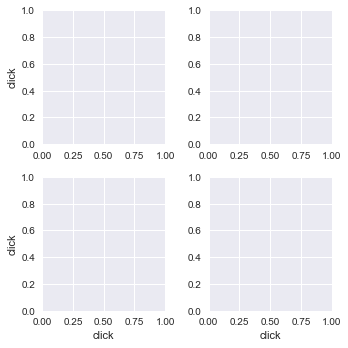

In [8]:
%matplotlib inline

@interact
def sns_scatter(Feature_x=column_name, Feature_y=column_name):
    
    scatter_list = [Feature_x, Feature_y]

    sns.set(color_codes=True)
    sns.pairplot(data[scatter_list])

<a id='1.1'></a>
### Determine if there are missing values:

Result: There are no missing values.

In [14]:
data.isnull().values.ravel().sum()

0

In [15]:
holdout_data.isnull().values.ravel().sum()

0

In [16]:
data.isnull().sum() # There is no missing or null values in this dataset

click               0
hour                0
C1                  0
banner_pos          0
site_id             0
site_domain         0
site_category       0
app_id              0
app_domain          0
app_category        0
device_id           0
device_ip           0
device_model        0
device_type         0
device_conn_type    0
C14                 0
C15                 0
C16                 0
C17                 0
C18                 0
C19                 0
C20                 0
C21                 0
dtype: int64

In [17]:
holdout_data.isnull().sum() # There is no missing or null values in this dataset

hour                0
C1                  0
banner_pos          0
site_id             0
site_domain         0
site_category       0
app_id              0
app_domain          0
app_category        0
device_id           0
device_ip           0
device_model        0
device_type         0
device_conn_type    0
C14                 0
C15                 0
C16                 0
C17                 0
C18                 0
C19                 0
C20                 0
C21                 0
dtype: int64

In [18]:
def missing_values_table(df): 
        mis_val = df.isnull().sum()
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        return mis_val_table_ren_columns 

In [19]:
missing_values_table(data)

,Missing Values,% of Total Values
click,0,0.0
hour,0,0.0
C1,0,0.0
banner_pos,0,0.0
site_id,0,0.0
site_domain,0,0.0
site_category,0,0.0
app_id,0,0.0
app_domain,0,0.0
app_category,0,0.0


In [20]:
missing_values_table(holdout_data)

,Missing Values,% of Total Values
hour,0,0.0
C1,0,0.0
banner_pos,0,0.0
site_id,0,0.0
site_domain,0,0.0
site_category,0,0.0
app_id,0,0.0
app_domain,0,0.0
app_category,0,0.0
device_id,0,0.0


<a id='1.2'></a>
## Determine number of unique values for categorical columns:

'site_id', 'site_domain', 'app_id', 'app_domain', 'device_id', 'device_ip', 'device_model' & drop them

In [21]:
data['banner_pos'].unique()

array([0, 1, 4, 5, 2, 7, 3], dtype=int64)

Result: Keep the feature.

In [22]:
data['site_id'].unique()

array(['84c7ba46', '85f751fd', '1fbe01fe', ..., 'a3d9a1db', 'e5b64873',
       'ec2bc575'], dtype=object)

In [23]:
data['site_id'].value_counts()

85f751fd    1459633
1fbe01fe     647535
e151e245     264456
d9750ee7      96583
5b08c53b      90920
5b4d2eda      76937
856e6d3f      76490
a7853007      46083
b7e9786d      36910
5ee41ff2      34956
6399eda6      34803
5bcf81a2      33760
6256f5b4      31546
57ef2c87      30913
17caea14      28073
0a742914      27077
83a0ad1a      26798
57fe1b20      26302
e8f79e60      25733
e4d8dd7b      25706
d6137915      23441
12fb4121      19574
6c5b482c      19319
93eaba74      18693
e5c60a05      18069
9a977531      17460
bb4524e7      16836
5114c672      16493
e3c09f3a      15927
4bf5bbe2      14625
             ...   
ae4d9eb1          1
b349c9b1          1
9b7fbb81          1
fa43f4ce          1
5297c072          1
7621bb32          1
71e4a1bf          1
0c5d3b65          1
adfc7184          1
9f9372ab          1
d96f98c4          1
303ba0ee          1
2e1e57b2          1
4e7411ea          1
a9caff76          1
b3be620e          1
14f4797c          1
ea30701b          1
19b92c45          1


Result: The feature has too many unique values for the preliminary anaysis. Collapse it now. Consult with domain knowledge experts. 

In [162]:
data['C1'].unique()

array([1002, 1005, 1010, 1007, 1008, 1001, 1012], dtype=int64)

In [163]:
data['C14'].unique()

array([21689, 21234, 15706, ..., 18576, 18604, 24044], dtype=int64)

In [164]:
data['C15'].unique()

array([ 320,  300,  216,  728, 1024,  768,  480,  120], dtype=int64)

In [165]:
data['C16'].unique()

array([  50,   36,  250,   90,  480,  768, 1024,  320,   20], dtype=int64)

In [166]:
data['C17'].unique()

array([2496, 2434, 1722, 2333, 2161,  423, 2493, 1973,  571, 1800, 2480,
       1926, 1637,  112, 2371, 2497, 1974, 2270, 2295, 1899, 1092, 2374,
       1887, 1994, 2253, 2481, 2227, 2351, 1955, 2264, 2043, 2283, 1882,
       2372, 2271, 1993,  572,  576, 2162, 1752, 2307, 1863, 1895, 2331,
        196, 1784, 2323, 1248, 2039, 2316, 2060, 2467, 2446, 2485, 2036,
       2449, 1528, 1921, 1780, 2495,  122, 1401, 1447, 2394, 2339,  613,
       1934, 2471, 2478, 2325, 2153, 2312, 2263,  906, 2158, 1872, 2306,
        544, 1685, 2424, 2284, 2285, 1996, 2286, 1740,  898,  547, 2083,
       1991,  827, 2443, 1932, 2459, 2427, 1272,  768, 2465, 1698, 1884,
        394, 2304,  549,  901, 2260, 2303, 1255,  686, 2476, 2482,  937,
        178, 1769,  153, 1835, 2201, 2487, 2492,  761, 2229, 1873, 2418,
       2346, 2421, 2278, 2242, 2425,  479, 2292, 1507, 2420, 2225, 2206,
       2279, 2348,  550, 2281, 2282, 1939, 1965, 2397, 1960, 2438, 1008,
       2250, 2483, 2390, 2218, 2154, 2494, 2489, 21

In [168]:
data['C18'].unique()

array([3, 0, 2, 1], dtype=int64)

In [169]:
data['C19'].unique()

array([ 167,  163,   35,   39,  297,  161, 1319,  551,   43,  683,  431,
       1835,  303,  687,  427,  813, 1063,  681,  175,  171,   47, 1711,
        801, 1451,  291,   41,  943,  169, 1071,  423, 1315, 1327,  673,
        547,  559,  425,  679,  299,   33,   34,  553, 1447,  295,  811,
        555,  675, 1059,  809,  937,   45,  417,  545,  419, 1959, 1065,
        935,  815, 1583, 1195, 1839,  939,   38,  677,  290, 1831,  289,
        803, 1575], dtype=int64)

In [171]:
data['C20'].unique()

array([100191, 100088,     -1, 100148, 100083, 100076, 100084, 100188,
       100111, 100046, 100215, 100151, 100156, 100081, 100202, 100077,
       100106, 100217, 100130, 100000, 100210, 100105, 100034, 100041,
       100079, 100200, 100074, 100199, 100028, 100072, 100131, 100013,
       100075, 100048, 100228, 100002, 100097, 100050, 100020, 100163,
       100128, 100160, 100176, 100205, 100101, 100189, 100241, 100037,
       100194, 100103, 100233, 100166, 100062, 100065, 100063, 100021,
       100162, 100193, 100026, 100190, 100192, 100161, 100019, 100139,
       100025, 100056, 100126, 100060, 100172, 100150, 100049, 100003,
       100039, 100212, 100224, 100173, 100119, 100057, 100155, 100248,
       100149, 100054, 100206, 100068, 100086, 100094, 100053, 100137,
       100005, 100221, 100052, 100091, 100004, 100107, 100012, 100087,
       100183, 100117, 100141, 100170, 100225, 100093, 100064, 100171,
       100022, 100123, 100071, 100112, 100031, 100051, 100032, 100122,
      

In [172]:
data['C21'].unique()

array([ 23,  61,  79, 157,  32, 117,  13,  91,  15,  46,  42,  33,  48,
        52,  71,  95,  82, 101,  16, 156,  93,  94, 116, 100, 111,  20,
        43,  51, 195,  70,  69,  85,  17,  68, 112,  90, 221, 194, 110,
        35, 219, 102, 163, 178, 159, 108, 182, 171, 177, 204, 212, 126,
       253, 251,   1, 229, 246, 255,  76, 104], dtype=int64)

In [ ]:
data['site_domain'].unique()

In [25]:
data['site_domain'].value_counts()

c4e18dd6    1513458
f3845767     647535
7e091613     333182
7687a86e     128932
98572c79      99876
16a36ef3      85235
58a89a43      76490
b12b9f85      37378
9d54950b      37334
17d996e6      35420
968765cd      34803
28f93029      31546
bd6d812f      30913
d262cf1e      28894
0dde25ec      28073
510bd839      27077
5c9ae867      26798
5b626596      26385
c4342784      25733
a17bde68      25706
6b59f079      24460
bb1ef334      23441
7256c623      22019
a434fa42      20620
d733bbc3      16836
3f2f3819      16493
6b560cc1      14625
c1aa3c04      12920
27e3c518      12727
e2a5dc06      11643
             ...   
3126483e          1
3a49ece1          1
5bc0d713          1
49cb396e          1
282151d4          1
a4cfda5e          1
49a438e1          1
7e62f447          1
76200dc2          1
6e96616f          1
f6ea8b54          1
e9ffa76d          1
86c1d76e          1
7e7557bc          1
e4c44421          1
f1f5ecc1          1
a98d3f43          1
93874a03          1
a7c5d333          1


Result: The feature has too many unique values for the preliminary anaysis. Collapse it now. Consult with domain knowledge experts. 

In [26]:
data['site_category'].unique()

array(['50e219e0', '28905ebd', '3e814130', '76b2941d', 'f028772b',
       '335d28a8', '0569f928', '72722551', '75fa27f6', 'f66779e6',
       'c0dd3be3', 'a818d37a', 'dedf689d', '70fb0e29', 'bcf865d9',
       '8fd0aea4', 'e787de0e', '42a36e14', '5378d028', '9ccfa2ea',
       '74073276', 'c706e647', '110ab22d', 'da34532e'], dtype=object)

Result: Keep the feature.

In [27]:
data['app_id'].unique()

array(['ecad2386', '66a5f0f3', 'e2fcccd2', ..., 'd9fe2944', 'af3f2d83',
       '6b12878b'], dtype=object)

In [28]:
data['app_id'].value_counts()

ecad2386    2583263
92f5800b     155562
e2fcccd2     112884
febd1138      76007
9c13b419      75544
7358e05e      61847
a5184c22      49209
d36838b1      45647
685d1c4c      41092
54c5d545      39624
03528b27      32175
f0d41ff1      29664
e2a1ca37      28313
e9739828      28240
51cedd4e      23843
66f5e02e      22693
98fed791      21761
03a08c3f      21738
73206397      20103
f53417e1      19733
e96773f0      17917
ce183bbd      14676
be7c618d      12051
1dc72b4d      10606
f888bf4c      10224
396df801       9804
3c4b944d       8850
39947756       8666
cf0327f9       8632
3f2a6cbb       8340
             ...   
7c4af157          1
bc7f7792          1
fd7456eb          1
ea82ef1f          1
0c46c4a3          1
a9aea987          1
b69df539          1
c4b726d8          1
086d1ac0          1
d2be8797          1
6cc50ffe          1
9c198883          1
fe7dd787          1
ca244efa          1
d5868a3c          1
f2b184b6          1
1178e07f          1
52099d06          1
52e7dbe4          1


Result: The feature has too many unique values for the preliminary anaysis. Collapse it now. Consult with domain knowledge experts. 

In [29]:
data['app_id'].unique()

array(['ecad2386', '66a5f0f3', 'e2fcccd2', ..., 'd9fe2944', 'af3f2d83',
       '6b12878b'], dtype=object)

In [30]:
data['app_id'].value_counts()

ecad2386    2583263
92f5800b     155562
e2fcccd2     112884
febd1138      76007
9c13b419      75544
7358e05e      61847
a5184c22      49209
d36838b1      45647
685d1c4c      41092
54c5d545      39624
03528b27      32175
f0d41ff1      29664
e2a1ca37      28313
e9739828      28240
51cedd4e      23843
66f5e02e      22693
98fed791      21761
03a08c3f      21738
73206397      20103
f53417e1      19733
e96773f0      17917
ce183bbd      14676
be7c618d      12051
1dc72b4d      10606
f888bf4c      10224
396df801       9804
3c4b944d       8850
39947756       8666
cf0327f9       8632
3f2a6cbb       8340
             ...   
7c4af157          1
bc7f7792          1
fd7456eb          1
ea82ef1f          1
0c46c4a3          1
a9aea987          1
b69df539          1
c4b726d8          1
086d1ac0          1
d2be8797          1
6cc50ffe          1
9c198883          1
fe7dd787          1
ca244efa          1
d5868a3c          1
f2b184b6          1
1178e07f          1
52099d06          1
52e7dbe4          1


Result: The feature has too many unique values for the preliminary anaysis. Collapse it now. Consult with domain knowledge experts.

In [31]:
data['app_domain'].unique()

array(['7801e8d9', 'd9b5648e', '5c5a694b', '2347f47a', '82e27996',
       '45a51db4', 'aefc06bd', '0654b444', 'ad63ec9b', 'ae637522',
       '5c620f04', 'f2f777fb', '43cf4f06', '885c7f3f', '813f3323',
       '33da2e74', 'afdf1f54', '5b9c592b', 'c6824def', '6f7ca2ba',
       '828da833', 'b5f3b24a', 'db829551', 'b9528b13', '2b627705',
       '3feeed1e', '15ec7f39', '18eb4e75', '27ee373d', '90706f5d',
       'f3ad7798', '2022d54e', 'b8d325c3', 'e5d5313f', 'df32afa9',
       '5ac0b939', '15c23f8e', '0b7d3d7d', '47464e95', '56eabb45',
       'c91cbbb4', '6a0a3a9d', '51174fb1', 'dcb74110', 'e787a6bc',
       '7a9371fa', 'b408d42a', 'a271c340', '4fafd4c4', '88293ffa',
       '7bbb38df', '2c1c31c6', '6cf43c3b', 'b2816726', '1ea19ec4',
       '6c2d0c26', 'b398ab59', '449e219f', '86adec6c', '9ec164d3',
       '700adbf0', '0e8616ad', '64ae80a5', 'cb36afb8', '863f4950',
       '800100e0', 'fd0f197b', 'bd8c1fdc', 'fd5f0ee2', 'da1be86e',
       'ef1fc174', 'd3c75c8f', '1ed56ded', '0d79ee56', 'b12ff1

In [32]:
data['app_domain'].value_counts()

7801e8d9    2723709
2347f47a     523910
ae637522     188343
5c5a694b     112902
82e27996      76009
d9b5648e      71495
0e8616ad      65775
b9528b13      64967
b8d325c3      53389
aefc06bd      29869
df32afa9      28883
33da2e74      25866
6f7ca2ba      22694
5b9c592b      10224
885c7f3f       6801
5c620f04       6071
45a51db4       5756
b5f3b24a       4818
813f3323       2559
0654b444       2369
ad63ec9b       1794
c6824def       1448
a8b0bf20       1301
15ec7f39       1292
99b4c806       1039
828da833        819
448ca2e3        727
43cf4f06        723
f2f777fb        651
47464e95        459
             ...   
c9373861          1
55240cf0          1
4d86b5ce          1
78051bc0          1
c87b28e6          1
3c08d416          1
e29fc2b7          1
b398ab59          1
5d4da5b0          1
5ef0e2e9          1
e25eea83          1
1d1d4953          1
9ec8f0d8          1
c72257c6          1
5048f612          1
ee50c840          1
17578ec3          1
6de3d639          1
424d97b0          1


Result: The feature has too many unique values for the preliminary anaysis. Collapse it now. Consult with domain knowledge experts. 

In [33]:
data['app_category'].unique()

array(['07d7df22', 'cef3e649', '0f2161f8', 'f95efa07', '8ded1f7a',
       '75d80bbe', 'd1327cf5', 'dc97ec06', 'a3c42688', '4ce2e9fc',
       '09481d60', '7113d72a', 'fc6fa53d', '8df2e842', '0f9a328c',
       'a86a3e89', '4681bb9d', '879c24eb', '2281a340', '0bfbc358',
       '79f0b860', '86c1a5a3', '18b1e0be', 'a7fd01ec', 'f395a87f',
       '5326cf99', '2fc4f2aa', '0d82db25'], dtype=object)

Result: Keep the feature.

In [34]:
data['device_id'].unique()

array(['c357dbff', 'a99f214a', 'a7420ec6', ..., '160abe66', '1adadf86',
       '6d82a1ef'], dtype=object)

Result: The feature has too many unique values for the preliminary anaysis. Collapse it now. Consult with domain knowledge experts. 

In [35]:
data['device_ip'].unique()

array(['f1ac7184', 'fa60af6b', '431b3174', ..., '7c9e21ff', '56e0135b',
       '44e7d8bd'], dtype=object)

Result: The feature has too many unique values for the preliminary anaysis. Collapse it now. Consult with domain knowledge experts. 

In [36]:
data['device_model'].unique()

array(['373ecbe6', 'b4b19c97', 'f39b265e', ..., '6f9ad639', '412eb17f',
       '8473e978'], dtype=object)

Result: The feature has too many unique values for the preliminary anaysis. Collapse it now. Consult with domain knowledge experts. 

In [37]:
data['device_type'].unique()

array([0, 1, 4, 5, 2], dtype=int64)

Result: Keep the feature.

In [38]:
data['device_conn_type'].unique()

array([0, 2, 3, 5], dtype=int64)

Result: Keep the feature.

In [39]:
data['C14'].unique()

array([21689, 21234, 15706, ..., 18576, 18604, 24044], dtype=int64)

Result: Integer and unknown, therefore keep this feature.

In [40]:
data['C15'].unique()

array([ 320,  300,  216,  728, 1024,  768,  480,  120], dtype=int64)

Result: Integer and unknown, therefore keep this feature.

In [41]:
data['C16'].unique()

array([  50,   36,  250,   90,  480,  768, 1024,  320,   20], dtype=int64)

Result: Integer and unknown, therefore keep this feature.

In [42]:
data['C17'].unique()

array([2496, 2434, 1722, 2333, 2161,  423, 2493, 1973,  571, 1800, 2480,
       1926, 1637,  112, 2371, 2497, 1974, 2270, 2295, 1899, 1092, 2374,
       1887, 1994, 2253, 2481, 2227, 2351, 1955, 2264, 2043, 2283, 1882,
       2372, 2271, 1993,  572,  576, 2162, 1752, 2307, 1863, 1895, 2331,
        196, 1784, 2323, 1248, 2039, 2316, 2060, 2467, 2446, 2485, 2036,
       2449, 1528, 1921, 1780, 2495,  122, 1401, 1447, 2394, 2339,  613,
       1934, 2471, 2478, 2325, 2153, 2312, 2263,  906, 2158, 1872, 2306,
        544, 1685, 2424, 2284, 2285, 1996, 2286, 1740,  898,  547, 2083,
       1991,  827, 2443, 1932, 2459, 2427, 1272,  768, 2465, 1698, 1884,
        394, 2304,  549,  901, 2260, 2303, 1255,  686, 2476, 2482,  937,
        178, 1769,  153, 1835, 2201, 2487, 2492,  761, 2229, 1873, 2418,
       2346, 2421, 2278, 2242, 2425,  479, 2292, 1507, 2420, 2225, 2206,
       2279, 2348,  550, 2281, 2282, 1939, 1965, 2397, 1960, 2438, 1008,
       2250, 2483, 2390, 2218, 2154, 2494, 2489, 21

Result: Integer and unknown, therefore keep this feature.

In [43]:
data['C18'].unique()

array([3, 0, 2, 1], dtype=int64)

Result: Integer and unknown, therefore keep this feature.

In [44]:
data['C19'].unique()

array([ 167,  163,   35,   39,  297,  161, 1319,  551,   43,  683,  431,
       1835,  303,  687,  427,  813, 1063,  681,  175,  171,   47, 1711,
        801, 1451,  291,   41,  943,  169, 1071,  423, 1315, 1327,  673,
        547,  559,  425,  679,  299,   33,   34,  553, 1447,  295,  811,
        555,  675, 1059,  809,  937,   45,  417,  545,  419, 1959, 1065,
        935,  815, 1583, 1195, 1839,  939,   38,  677,  290, 1831,  289,
        803, 1575], dtype=int64)

Result: Integer and unknown, therefore keep this feature.

In [45]:
data['C20'].unique()

array([100191, 100088,     -1, 100148, 100083, 100076, 100084, 100188,
       100111, 100046, 100215, 100151, 100156, 100081, 100202, 100077,
       100106, 100217, 100130, 100000, 100210, 100105, 100034, 100041,
       100079, 100200, 100074, 100199, 100028, 100072, 100131, 100013,
       100075, 100048, 100228, 100002, 100097, 100050, 100020, 100163,
       100128, 100160, 100176, 100205, 100101, 100189, 100241, 100037,
       100194, 100103, 100233, 100166, 100062, 100065, 100063, 100021,
       100162, 100193, 100026, 100190, 100192, 100161, 100019, 100139,
       100025, 100056, 100126, 100060, 100172, 100150, 100049, 100003,
       100039, 100212, 100224, 100173, 100119, 100057, 100155, 100248,
       100149, 100054, 100206, 100068, 100086, 100094, 100053, 100137,
       100005, 100221, 100052, 100091, 100004, 100107, 100012, 100087,
       100183, 100117, 100141, 100170, 100225, 100093, 100064, 100171,
       100022, 100123, 100071, 100112, 100031, 100051, 100032, 100122,
      

In [46]:
data['C20'].value_counts()

-1         1893272
 100084     244169
 100148     179629
 100111     171955
 100077     157843
 100075     154721
 100081     133581
 100083     106987
 100156     103391
 100193      70531
 100176      65179
 100074      58691
 100079      57814
 100189      47473
 100076      45772
 100192      23555
 100190      22596
 100191      22421
 100188      22007
 100013      19874
 100031      18818
 100155      16206
 100194      14626
 100181      14285
 100000      13751
 100233      11781
 100105      11777
 100182      11664
 100003      11523
 100119      11477
            ...   
 100121        214
 100229        213
 100073        189
 100224        184
 100099        141
 100043        140
 100244        122
 100163        108
 100010         98
 100178         93
 100213         82
 100024         75
 100109         71
 100122         68
 100108         62
 100137         61
 100082         58
 100169         53
 100153         47
 100175         28
 100138         11
 100100     

Observation: This mysterious -1 has 1893272 occurences.

In [47]:
data['C21'].unique()

array([ 23,  61,  79, 157,  32, 117,  13,  91,  15,  46,  42,  33,  48,
        52,  71,  95,  82, 101,  16, 156,  93,  94, 116, 100, 111,  20,
        43,  51, 195,  70,  69,  85,  17,  68, 112,  90, 221, 194, 110,
        35, 219, 102, 163, 178, 159, 108, 182, 171, 177, 204, 212, 126,
       253, 251,   1, 229, 246, 255,  76, 104], dtype=int64)

In [51]:
data.columns

Index(['click', 'hour', 'C1', 'banner_pos', 'site_id', 'site_domain',
       'site_category', 'app_id', 'app_domain', 'app_category', 'device_id',
       'device_ip', 'device_model', 'device_type', 'device_conn_type', 'C14',
       'C15', 'C16', 'C17', 'C18', 'C19', 'C20', 'C21'],
      dtype='object')

In [52]:
data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
click,4042896.0,1.697231e-01,0.375389,0.0,0.0,0.0,0.0,1.0
hour,4042896.0,1.410256e+07,296.683743,14102100.0,14102304.0,14102602.0,14102814.0,14103023.0
C1,4042896.0,1.004967e+03,1.094734,1001.0,1005.0,1005.0,1005.0,1012.0
banner_pos,4042896.0,2.881150e-01,0.506325,0.0,0.0,0.0,1.0,7.0
device_type,4042896.0,1.015020e+00,0.527009,0.0,1.0,1.0,1.0,5.0
device_conn_type,4042896.0,3.311861e-01,0.854833,0.0,0.0,0.0,0.0,5.0
C14,4042896.0,1.884111e+04,4961.959014,375.0,16920.0,20346.0,21894.0,24052.0
C15,4042896.0,3.188821e+02,21.277312,120.0,320.0,320.0,320.0,1024.0
C16,4042896.0,6.009853e+01,47.311173,20.0,50.0,50.0,50.0,1024.0
C17,4042896.0,2.112450e+03,609.718278,112.0,1863.0,2323.0,2526.0,2758.0


In [53]:
data['click'].unique()

array([0, 1], dtype=int64)

In [54]:
data['click'].count()

4042896

In [55]:
data.groupby('click').count()

,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,device_id,...,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
click,,,,,,,,,,,,,,,,,,,,,
0,3356723,3356723,3356723,3356723,3356723,3356723,3356723,3356723,3356723,3356723,...,3356723,3356723,3356723,3356723,3356723,3356723,3356723,3356723,3356723,3356723
1,686173,686173,686173,686173,686173,686173,686173,686173,686173,686173,...,686173,686173,686173,686173,686173,686173,686173,686173,686173,686173


<a id='1.4'></a>
## Target Variable EDA

In [56]:
data['click'].value_counts()

0    3356723
1     686173
Name: click, dtype: int64

In [57]:
Counter(data['click'])

Counter({0: 3356723, 1: 686173})

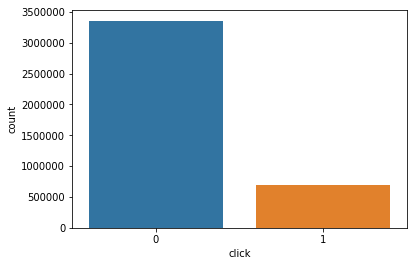

In [58]:
sns.countplot(x='click', data=data)

Observation: The target class is lower than the non-target class. Balanced data would mean 50% points for each of the class. For most machine learning techniques, little imbalance is not a problem. Only when the class imbalance is high, e.g. 90% points for one class and 10% for the other, standard optimization criteria or performance measures may not be as effective and would need modification. This is not the case here.

<a id='1.5'></a>
## Time Feature

In [16]:
%%time

#Convert numeric to string to date time type

data['hour'] = pd.to_datetime(data['hour'].astype(str), format='%y%M%d%H')

winsound.Beep(500,10000)

Wall time: 24.9 s


In [4]:
%%time

#Convert numeric to string to date time type

holdout_data['hour'] = pd.to_datetime(holdout_data['hour'].astype(str), format='%y%M%d%H')

winsound.Beep(500,10000)

Wall time: 27.2 s


In [62]:
data.head()

,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,...,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
id,,,,,,,,,,,,,,,,,,,,,
10001264480619467364,0,2014-01-21 00:10:00,1002,0,84c7ba46,c4e18dd6,50e219e0,ecad2386,7801e8d9,07d7df22,...,0,0,21689,320,50,2496,3,167,100191,23
10004482643316086592,0,2014-01-21 00:10:00,1005,0,85f751fd,c4e18dd6,50e219e0,66a5f0f3,d9b5648e,cef3e649,...,1,0,21234,320,50,2434,3,163,100088,61
10005951398749600249,0,2014-01-21 00:10:00,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,...,1,0,15706,320,50,1722,0,35,-1,79
10007164336863914220,1,2014-01-21 00:10:00,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,...,1,0,15706,320,50,1722,0,35,-1,79
10009635774586344851,0,2014-01-21 00:10:00,1005,0,543a539e,c7ca3108,3e814130,ecad2386,7801e8d9,07d7df22,...,1,0,20352,320,50,2333,0,39,-1,157


In [63]:
data.info()

<class 'pandas.core.frame.DataFrame'>
UInt64Index: 4042896 entries, 10001264480619467364 to 9998515968748286661
Data columns (total 23 columns):
click               int64
hour                datetime64[ns]
C1                  int64
banner_pos          int64
site_id             object
site_domain         object
site_category       object
app_id              object
app_domain          object
app_category        object
device_id           object
device_ip           object
device_model        object
device_type         int64
device_conn_type    int64
C14                 int64
C15                 int64
C16                 int64
C17                 int64
C18                 int64
C19                 int64
C20                 int64
C21                 int64
dtypes: datetime64[ns](1), int64(13), object(9)
memory usage: 900.3+ MB


<a id='2.1'></a>
### Correlation Analysis: NA since all independent variables are categorical

In [64]:
data.corr()

,click,C1,banner_pos,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
click,1.000000,-0.036949,0.026660,-0.038175,-0.083398,-0.060500,-0.032577,0.129268,-0.055974,0.021266,-0.004735,-0.057941,-0.070181
C1,-0.036949,1.000000,0.288149,0.894256,0.195651,0.055674,0.120828,0.062997,0.064194,-0.041763,0.002637,-0.034765,0.035879
banner_pos,0.026660,0.288149,1.000000,0.323050,-0.084046,-0.012666,0.061349,0.022606,-0.031958,0.094585,0.131178,0.054591,-0.096916
device_type,-0.038175,0.894256,0.323050,1.000000,0.208431,0.044446,0.179348,0.065255,0.050479,-0.046364,-0.001941,-0.047997,0.035993
device_conn_type,-0.083398,0.195651,-0.084046,0.208431,1.000000,0.067480,0.069120,-0.014790,0.079737,-0.061556,-0.009596,0.089693,0.062013
C14,-0.060500,0.055674,-0.012666,0.044446,0.067480,1.000000,0.002758,0.037283,0.976758,-0.231041,-0.132782,0.023969,0.409526
C15,-0.032577,0.120828,0.061349,0.179348,0.069120,0.002758,1.000000,-0.071959,0.001494,0.012706,0.050181,0.008442,0.001455
C16,0.129268,0.062997,0.022606,0.065255,-0.014790,0.037283,-0.071959,1.000000,0.047482,0.083961,-0.073695,-0.045093,-0.084972
C17,-0.055974,0.064194,-0.031958,0.050479,0.079737,0.976758,0.001494,0.047482,1.000000,-0.246130,-0.128567,0.008373,0.422745
C18,0.021266,-0.041763,0.094585,-0.046364,-0.061556,-0.231041,0.012706,0.083961,-0.246130,1.000000,0.095150,0.010643,-0.545294


<a id='2'></a>
## Pre-Processing Data

<a id='2.1'></a>
### Converting Categorical Features

I needed to convert all the features to dummy variables and determine when to collapse unique values. Generall, I chose <.01 as a cutoff. I left the dependent variables as is. I wanted to limit the size of the final matrix and utilize the most important features/values.

In [341]:
data.head()

,click,hour,C1,site_category,app_category,device_id,device_conn_type,C14,C15,C16,...,app_category_n,device_type_n,C1_n,C14_n,C15_n,C16_n,C17_n,C19_n,C20_n,C21_n
id,,,,,,,,,,,,,,,,,,,,,
10001264480619467364,0,2014-01-21 00:10:00,1002,50e219e0,07d7df22,c357dbff,0,21689,320,50,...,0,99,1,99,0,0,99,2,99,0.0
10004482643316086592,0,2014-01-21 00:10:00,1005,50e219e0,cef3e649,a99f214a,0,21234,320,50,...,2,99,0,99,0,0,99,7,99,5.0
10005951398749600249,0,2014-01-21 00:10:00,1005,28905ebd,07d7df22,a99f214a,0,15706,320,50,...,0,99,18,18,0,0,0,0,0,2.0
10007164336863914220,1,2014-01-21 00:10:00,1005,28905ebd,07d7df22,a99f214a,0,15706,320,50,...,0,99,18,18,0,0,0,0,0,2.0
10009635774586344851,0,2014-01-21 00:10:00,1005,3e814130,07d7df22,a99f214a,0,20352,320,50,...,0,99,0,99,0,0,17,1,0,6.0


#### Given that this is the priliminary analysis and memory issues, I am going to collapse columns where appropriate.

## Banner_pos

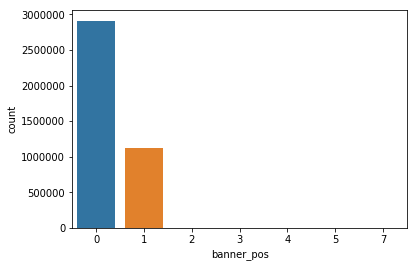

In [348]:
sns.countplot(x='banner_pos', data=data)

In [349]:
data['banner_pos'].value_counts(normalize=True)

0    0.719901
1    0.278319
7    0.001075
2    0.000322
4    0.000185
5    0.000146
3    0.000051
Name: banner_pos, dtype: float64

<a id='2.1.1'></a>
#### Result:

Collapse banner_pos 2,3,4,5,7 into one "other" category called 2 

In [20]:
%%time

data['banner_pos_n'] = 99
data.loc[data['banner_pos'] == 0, 'banner_pos_n'] = 0
data.loc[data['banner_pos'] == 1, 'banner_pos_n'] = 1

Wall time: 733 ms


In [21]:
%%time

holdout_data['banner_pos_n_h'] = 99
holdout_data.loc[holdout_data['banner_pos'] == 0, 'banner_pos_n_h'] = 0
holdout_data.loc[holdout_data['banner_pos'] == 1, 'banner_pos_n_h'] = 1

Wall time: 890 ms


In [71]:
data[['banner_pos','banner_pos_n']].head()

,banner_pos,banner_pos_n
id,,
10001264480619467364,0,0
10004482643316086592,0,0
10005951398749600249,0,0
10007164336863914220,0,0
10009635774586344851,0,0


In [75]:
data.head()

,click,hour,C1,site_id,site_domain,site_category,app_id,app_domain,app_category,device_id,...,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21,banner_pos_n
id,,,,,,,,,,,,,,,,,,,,,
10001264480619467364,0,2014-01-21 00:10:00,1002,84c7ba46,c4e18dd6,50e219e0,ecad2386,7801e8d9,07d7df22,c357dbff,...,0,21689,320,50,2496,3,167,100191,23,0
10004482643316086592,0,2014-01-21 00:10:00,1005,85f751fd,c4e18dd6,50e219e0,66a5f0f3,d9b5648e,cef3e649,a99f214a,...,0,21234,320,50,2434,3,163,100088,61,0
10005951398749600249,0,2014-01-21 00:10:00,1005,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,a99f214a,...,0,15706,320,50,1722,0,35,-1,79,0
10007164336863914220,1,2014-01-21 00:10:00,1005,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,a99f214a,...,0,15706,320,50,1722,0,35,-1,79,0
10009635774586344851,0,2014-01-21 00:10:00,1005,543a539e,c7ca3108,3e814130,ecad2386,7801e8d9,07d7df22,a99f214a,...,0,20352,320,50,2333,0,39,-1,157,0


## Site_category

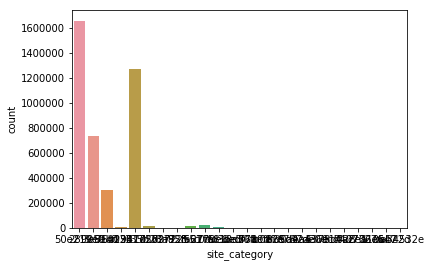

In [83]:
sns.countplot(x='site_category', data=data)

In [ ]:
data.info()

In [ ]:
data['site_category'].value_counts(normalize=True)

<a id='2.1.2'></a>
#### Result: 

Collapse all of the site categories below 1 * 10^-3 into one "other" category.

In [22]:
%%time

data['site_category_n'] = 99
data.loc[data['site_category'] == '50e219e0', 'site_category_n'] = 0
data.loc[data['site_category'] == 'f028772b', 'site_category_n'] = 1
data.loc[data['site_category'] == '28905ebd', 'site_category_n'] = 2
data.loc[data['site_category'] == '3e814130', 'site_category_n'] = 3
data.loc[data['site_category'] == 'f66779e6', 'site_category_n'] = 4
data.loc[data['site_category'] == '75fa27f6', 'site_category_n'] = 5
data.loc[data['site_category'] == '335d28a8', 'site_category_n'] = 6
data.loc[data['site_category'] == '76b2941d', 'site_category_n'] = 7
data.loc[data['site_category'] == 'c0dd3be3', 'site_category_n'] = 8

Wall time: 4.61 s


In [23]:
%%time

holdout_data['site_category_n_h'] = 99
holdout_data.loc[holdout_data['site_category'] == '50e219e0', 'site_category_n_h'] = 0
holdout_data.loc[holdout_data['site_category'] == 'f028772b', 'site_category_n_h'] = 1
holdout_data.loc[holdout_data['site_category'] == '28905ebd', 'site_category_n_h'] = 2
holdout_data.loc[holdout_data['site_category'] == '3e814130', 'site_category_n_h'] = 3
holdout_data.loc[holdout_data['site_category'] == 'f66779e6', 'site_category_n_h'] = 4
holdout_data.loc[holdout_data['site_category'] == '75fa27f6', 'site_category_n_h'] = 5
holdout_data.loc[holdout_data['site_category'] == '335d28a8', 'site_category_n_h'] = 6
holdout_data.loc[holdout_data['site_category'] == '76b2941d', 'site_category_n_h'] = 7
holdout_data.loc[holdout_data['site_category'] == 'c0dd3be3', 'site_category_n_h'] = 8

Wall time: 5.21 s


In [ ]:
data[['site_category','site_category_n']].head()

In [ ]:
data.head()

## App_cateogry

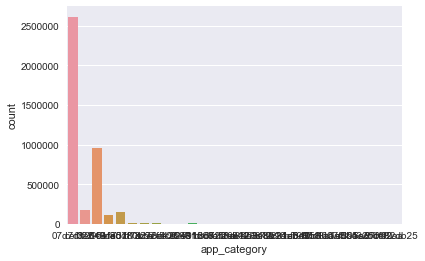

In [11]:
sns.countplot(x='app_category', data=data)

In [12]:
data['app_category'].value_counts(normalize=True)

07d7df22    6.472519e-01
0f2161f8    2.362079e-01
cef3e649    4.290192e-02
8ded1f7a    3.642661e-02
f95efa07    2.822630e-02
d1327cf5    3.067356e-03
09481d60    1.385393e-03
dc97ec06    1.374262e-03
75d80bbe    9.832061e-04
fc6fa53d    5.938812e-04
4ce2e9fc    4.964263e-04
879c24eb    3.007745e-04
a3c42688    2.639197e-04
4681bb9d    1.602811e-04
0f9a328c    1.375252e-04
a86a3e89    6.307360e-05
2281a340    5.763195e-05
8df2e842    4.279111e-05
79f0b860    1.508819e-05
0bfbc358    1.212002e-05
a7fd01ec    6.925728e-06
18b1e0be    6.925728e-06
7113d72a    6.925728e-06
2fc4f2aa    5.194296e-06
5326cf99    4.452254e-06
0d82db25    7.420423e-07
f395a87f    2.473474e-07
86c1a5a3    2.473474e-07
Name: app_category, dtype: float64

<a id='2.1.3'></a>
#### Result: 

Collapse all of the site categories below 1 * 10^-3 into one "other" category.

In [24]:
%%time

data['app_category_n'] = 99
data.loc[data['app_category'] == '07d7df22', 'app_category_n'] = 0
data.loc[data['app_category'] == '0f2161f8', 'app_category_n'] = 1
data.loc[data['app_category'] == 'cef3e649', 'app_category_n'] = 2
data.loc[data['app_category'] == '8ded1f7a', 'app_category_n'] = 3
data.loc[data['app_category'] == 'd1327cf5', 'app_category_n'] = 4
data.loc[data['app_category'] == '09481d60', 'app_category_n'] = 5
data.loc[data['app_category'] == 'dc97ec06', 'app_category_n'] = 6
data.loc[data['app_category'] == '75d80bbe', 'app_category_n'] = 7

Wall time: 3.5 s


In [25]:
%%time

holdout_data['app_category_n_h'] = 99
holdout_data.loc[holdout_data['app_category'] == '07d7df22', 'app_category_n_h'] = 0
holdout_data.loc[holdout_data['app_category'] == '0f2161f8', 'app_category_n_h'] = 1
holdout_data.loc[holdout_data['app_category'] == 'cef3e649', 'app_category_n_h'] = 2
holdout_data.loc[holdout_data['app_category'] == '8ded1f7a', 'app_category_n_h'] = 3
holdout_data.loc[holdout_data['app_category'] == 'd1327cf5', 'app_category_n_h'] = 4
holdout_data.loc[holdout_data['app_category'] == '09481d60', 'app_category_n_h'] = 5
holdout_data.loc[holdout_data['app_category'] == 'dc97ec06', 'app_category_n_h'] = 6
holdout_data.loc[holdout_data['app_category'] == '75d80bbe', 'app_category_n_h'] = 7

Wall time: 4.63 s


In [26]:
data[['app_category','app_category_n']].head()

,app_category,app_category_n
id,,
10001264480619467364,07d7df22,0
10004482643316086592,cef3e649,2
10005951398749600249,07d7df22,0
10007164336863914220,07d7df22,0
10009635774586344851,07d7df22,0


In [ ]:
data.head()

## Device_type

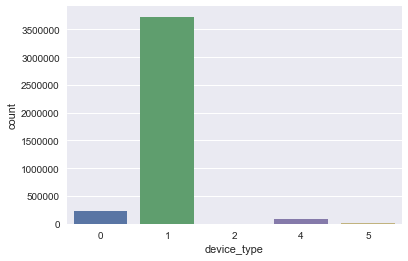

In [9]:
sns.countplot(x='device_type', data=data)

In [10]:
data['device_type'].value_counts(normalize=True)

1    9.226653e-01
0    5.504173e-02
4    1.910759e-02
5    3.184598e-03
2    7.420423e-07
Name: device_type, dtype: float64

<a id='2.1.4'></a>
#### Result: 

Collapse device_type 2 & 5 into one "other" category called 99

In [27]:
%%time

data['device_type_n'] = 99
data.loc[data['device_type'] == 0, 'device_type_n'] = 0
data.loc[data['device_type'] == 1, 'device_type_n'] = 1
data.loc[data['device_type'] == 4, 'device_type_n'] = 4

Wall time: 844 ms


In [28]:
%%time

holdout_data['device_type_n_h'] = 99
holdout_data.loc[holdout_data['device_type'] == 0, 'device_type_n_h'] = 0
holdout_data.loc[holdout_data['device_type'] == 1, 'device_type_n_h'] = 1
holdout_data.loc[holdout_data['device_type'] == 4, 'device_type_n_h'] = 4

Wall time: 1.59 s


In [29]:
data[['device_type','device_type_n']].head()

,device_type,device_type_n
id,,
10001264480619467364,0,0
10004482643316086592,1,1
10005951398749600249,1,1
10007164336863914220,1,1
10009635774586344851,1,1


In [87]:
data.head()

,click,hour,C1,site_id,site_domain,site_category,app_id,app_domain,app_category,device_id,...,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21,banner_pos_n
id,,,,,,,,,,,,,,,,,,,,,
10001264480619467364,0,2014-01-21 00:10:00,1002,84c7ba46,c4e18dd6,50e219e0,ecad2386,7801e8d9,07d7df22,c357dbff,...,0,21689,320,50,2496,3,167,100191,23,0
10004482643316086592,0,2014-01-21 00:10:00,1005,85f751fd,c4e18dd6,50e219e0,66a5f0f3,d9b5648e,cef3e649,a99f214a,...,0,21234,320,50,2434,3,163,100088,61,0
10005951398749600249,0,2014-01-21 00:10:00,1005,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,a99f214a,...,0,15706,320,50,1722,0,35,-1,79,0
10007164336863914220,1,2014-01-21 00:10:00,1005,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,a99f214a,...,0,15706,320,50,1722,0,35,-1,79,0
10009635774586344851,0,2014-01-21 00:10:00,1005,543a539e,c7ca3108,3e814130,ecad2386,7801e8d9,07d7df22,a99f214a,...,0,20352,320,50,2333,0,39,-1,157,0


## Device_conn_type

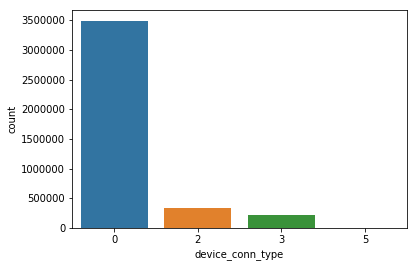

In [89]:
sns.countplot(x='device_conn_type', data=data)

In [90]:
data['device_conn_type'].value_counts(normalize=True)

0    0.863010
2    0.081929
3    0.053989
5    0.001072
Name: device_conn_type, dtype: float64

<a id='2.1.5'></a>
#### Result:

Keep all

In [46]:
data.columns

Index(['click', 'hour', 'C1', 'banner_pos', 'site_id', 'site_domain',
       'site_category', 'app_id', 'app_domain', 'app_category', 'device_id',
       'device_ip', 'device_model', 'device_type', 'device_conn_type', 'C14',
       'C15', 'C16', 'C17', 'C18', 'C19', 'C20', 'C21', 'banner_pos_n',
       'site_category_n', 'app_category_n', 'device_type_n', 'site_id_n',
       'site_domain_n', 'app_id_n', 'app_domain_n', 'device_model_n', 'C14_n',
       'C17_n', 'C19_n', 'C20_n', 'C21_n', 'device_con_type_n'],
      dtype='object')

## Site_id

In [92]:
data['site_id'].value_counts(normalize=True)

85f751fd    3.610365e-01
1fbe01fe    1.601661e-01
e151e245    6.541252e-02
d9750ee7    2.388956e-02
5b08c53b    2.248883e-02
5b4d2eda    1.903017e-02
856e6d3f    1.891961e-02
a7853007    1.139851e-02
b7e9786d    9.129594e-03
5ee41ff2    8.646277e-03
6399eda6    8.608433e-03
5bcf81a2    8.350450e-03
6256f5b4    7.802823e-03
57ef2c87    7.646252e-03
17caea14    6.943785e-03
0a742914    6.697427e-03
83a0ad1a    6.628417e-03
57fe1b20    6.505733e-03
e8f79e60    6.364992e-03
e4d8dd7b    6.358313e-03
d6137915    5.798071e-03
12fb4121    4.841579e-03
6c5b482c    4.778505e-03
93eaba74    4.623666e-03
e5c60a05    4.469321e-03
9a977531    4.318686e-03
bb4524e7    4.164342e-03
5114c672    4.079501e-03
e3c09f3a    3.939503e-03
4bf5bbe2    3.617456e-03
                ...     
ae4d9eb1    2.473474e-07
b349c9b1    2.473474e-07
9b7fbb81    2.473474e-07
fa43f4ce    2.473474e-07
5297c072    2.473474e-07
7621bb32    2.473474e-07
71e4a1bf    2.473474e-07
0c5d3b65    2.473474e-07
adfc7184    2.473474e-07


<a id='2.1.6'></a>
#### Result for site_id:

Kept 85f751fd, 1fbe01fe, e151e245, d9750ee7, 5b08c53b, 5b4d2eda, 856e6d3f, a7853007 and collapsed rest into one category, 99.

In [30]:
%%time

data['site_id_n'] = 99
data.loc[data['site_id'] == '85f751fd', 'site_id_n'] = 0
data.loc[data['site_id'] == '1fbe01fe', 'site_id_n'] = 1
data.loc[data['site_id'] == 'e151e245', 'site_id_n'] = 2
data.loc[data['site_id'] == 'd9750ee7', 'site_id_n'] = 3
data.loc[data['site_id'] == '5b08c53b', 'site_id_n'] = 4
data.loc[data['site_id'] == '5b4d2eda', 'site_id_n'] = 5
data.loc[data['site_id'] == '856e6d3f', 'site_id_n'] = 6
data.loc[data['site_id'] == 'a7853007', 'site_id_n'] = 7

Wall time: 3.95 s


In [31]:
%%time

holdout_data['site_id_n_h'] = 99
holdout_data.loc[holdout_data['site_id'] == '85f751fd', 'site_id_n_h'] = 0
holdout_data.loc[holdout_data['site_id'] == '1fbe01fe', 'site_id_n_h'] = 1
holdout_data.loc[holdout_data['site_id'] == 'e151e245', 'site_id_n_h'] = 2
holdout_data.loc[holdout_data['site_id'] == 'd9750ee7', 'site_id_n_h'] = 3
holdout_data.loc[holdout_data['site_id'] == '5b08c53b', 'site_id_n_h'] = 4
holdout_data.loc[holdout_data['site_id'] == '5b4d2eda', 'site_id_n_h'] = 5
holdout_data.loc[holdout_data['site_id'] == '856e6d3f', 'site_id_n_h'] = 6
holdout_data.loc[holdout_data['site_id'] == 'a7853007', 'site_id_n_h'] = 7

Wall time: 4.95 s


## Site_domain

In [97]:
data['site_domain'].value_counts(normalize=True)

c4e18dd6    3.743500e-01
f3845767    1.601661e-01
7e091613    8.241172e-02
7687a86e    3.189100e-02
98572c79    2.470407e-02
16a36ef3    2.108266e-02
58a89a43    1.891961e-02
b12b9f85    9.245353e-03
9d54950b    9.234470e-03
17d996e6    8.761047e-03
968765cd    8.608433e-03
28f93029    7.802823e-03
bd6d812f    7.646252e-03
d262cf1e    7.146857e-03
0dde25ec    6.943785e-03
510bd839    6.697427e-03
5c9ae867    6.628417e-03
5b626596    6.526262e-03
c4342784    6.364992e-03
a17bde68    6.358313e-03
6b59f079    6.050119e-03
bb1ef334    5.798071e-03
7256c623    5.446343e-03
a434fa42    5.100304e-03
d733bbc3    4.164342e-03
3f2f3819    4.079501e-03
6b560cc1    3.617456e-03
c1aa3c04    3.195729e-03
27e3c518    3.147991e-03
e2a5dc06    2.879866e-03
                ...     
3126483e    2.473474e-07
3a49ece1    2.473474e-07
5bc0d713    2.473474e-07
49cb396e    2.473474e-07
282151d4    2.473474e-07
a4cfda5e    2.473474e-07
49a438e1    2.473474e-07
7e62f447    2.473474e-07
76200dc2    2.473474e-07


<a id='2.1.6'></a>
#### Result for sitde_domain:

Kept c4e18dd6, f3845767, 7e091613, 7687a86e, 98572c79, 16a36ef3, 58a89a43 and collapsed rest into one category, 99.

In [32]:
%%time

data['site_domain_n'] = 99
data.loc[data['site_domain'] == 'c4e18dd6', 'site_domain_n'] = 0
data.loc[data['site_domain'] == 'f3845767', 'site_domain_n'] = 1
data.loc[data['site_domain'] == '7e091613', 'site_domain_n'] = 2
data.loc[data['site_domain'] == '7687a86e', 'site_domain_n'] = 3
data.loc[data['site_domain'] == '98572c79', 'site_domain_n'] = 4
data.loc[data['site_domain'] == '16a36ef3', 'site_domain_n'] = 5
data.loc[data['site_domain'] == '58a89a43', 'site_domain_n'] = 6

Wall time: 4.04 s


In [33]:
%%time

holdout_data['site_domain_n_h'] = 99
holdout_data.loc[holdout_data['site_domain'] == 'c4e18dd6', 'site_domain_n_h'] = 0
holdout_data.loc[holdout_data['site_domain'] == 'f3845767', 'site_domain_n_h'] = 1
holdout_data.loc[holdout_data['site_domain'] == '7e091613', 'site_domain_n_h'] = 2
holdout_data.loc[holdout_data['site_domain'] == '7687a86e', 'site_domain_n_h'] = 3
holdout_data.loc[holdout_data['site_domain'] == '98572c79', 'site_domain_n_h'] = 4
holdout_data.loc[holdout_data['site_domain'] == '16a36ef3', 'site_domain_n_h'] = 5
holdout_data.loc[holdout_data['site_domain'] == '58a89a43', 'site_domain_n_h'] = 6

Wall time: 4.2 s


## App_id

In [102]:
data['app_id'].value_counts(normalize=True)

ecad2386    6.389635e-01
92f5800b    3.847786e-02
e2fcccd2    2.792157e-02
febd1138    1.880014e-02
9c13b419    1.868562e-02
7358e05e    1.529770e-02
a5184c22    1.217172e-02
d36838b1    1.129067e-02
685d1c4c    1.016400e-02
54c5d545    9.800895e-03
03528b27    7.958404e-03
f0d41ff1    7.337315e-03
e2a1ca37    7.003148e-03
e9739828    6.985092e-03
51cedd4e    5.897505e-03
66f5e02e    5.613056e-03
98fed791    5.382528e-03
03a08c3f    5.376839e-03
73206397    4.972426e-03
f53417e1    4.880907e-03
e96773f0    4.431724e-03
ce183bbd    3.630071e-03
be7c618d    2.980784e-03
1dc72b4d    2.623367e-03
f888bf4c    2.528880e-03
396df801    2.424994e-03
3c4b944d    2.189025e-03
39947756    2.143513e-03
cf0327f9    2.135103e-03
3f2a6cbb    2.062878e-03
                ...     
7c4af157    2.473474e-07
bc7f7792    2.473474e-07
fd7456eb    2.473474e-07
ea82ef1f    2.473474e-07
0c46c4a3    2.473474e-07
a9aea987    2.473474e-07
b69df539    2.473474e-07
c4b726d8    2.473474e-07
086d1ac0    2.473474e-07


<a id='2.1.7'></a>
#### Result for app_id:

Kept ecad2386, 92f5800b, e2fcccd2, febd1138, 9c13b419, 7358e05e, a5184c22, d36838b1, 685d1c4c, and collapsed rest into one category, 99.

In [34]:
%%time

data['app_id_n'] = 99
data.loc[data['app_id'] == 'ecad2386', 'app_id_n'] = 0
data.loc[data['app_id'] == '92f5800b', 'app_id_n'] = 1
data.loc[data['app_id'] == 'e2fcccd2', 'app_id_n'] = 2
data.loc[data['app_id'] == 'febd1138', 'app_id_n'] = 3
data.loc[data['app_id'] == '9c13b419', 'app_id_n'] = 4
data.loc[data['app_id'] == '7358e05e', 'app_id_n'] = 5
data.loc[data['app_id'] == 'a5184c22', 'app_id_n'] = 6
data.loc[data['app_id'] == 'd36838b1', 'app_id_n'] = 7
data.loc[data['app_id'] == '685d1c4c', 'app_id_n'] = 8

Wall time: 3.99 s


In [35]:
%%time

holdout_data['app_id_n_h'] = 99
holdout_data.loc[holdout_data['app_id'] == 'ecad2386', 'app_id_n_h'] = 0
holdout_data.loc[holdout_data['app_id'] == '92f5800b', 'app_id_n_h'] = 1
holdout_data.loc[holdout_data['app_id'] == 'e2fcccd2', 'app_id_n_h'] = 2
holdout_data.loc[holdout_data['app_id'] == 'febd1138', 'app_id_n_h'] = 3
holdout_data.loc[holdout_data['app_id'] == '9c13b419', 'app_id_n_h'] = 4
holdout_data.loc[holdout_data['app_id'] == '7358e05e', 'app_id_n_h'] = 5
holdout_data.loc[holdout_data['app_id'] == 'a5184c22', 'app_id_n_h'] = 6
holdout_data.loc[holdout_data['app_id'] == 'd36838b1', 'app_id_n_h'] = 7
holdout_data.loc[holdout_data['app_id'] == '685d1c4c', 'app_id_n_h'] = 8

Wall time: 5.38 s


## App_domain

In [111]:
data['app_domain'].value_counts(normalize=True)

7801e8d9    6.737025e-01
2347f47a    1.295878e-01
ae637522    4.658616e-02
5c5a694b    2.792602e-02
82e27996    1.880063e-02
d9b5648e    1.768411e-02
0e8616ad    1.626928e-02
b9528b13    1.606942e-02
b8d325c3    1.320563e-02
aefc06bd    7.388021e-03
df32afa9    7.144136e-03
33da2e74    6.397889e-03
6f7ca2ba    5.613303e-03
5b9c592b    2.528880e-03
885c7f3f    1.682210e-03
5c620f04    1.501646e-03
45a51db4    1.423732e-03
b5f3b24a    1.191720e-03
813f3323    6.329621e-04
0654b444    5.859661e-04
ad63ec9b    4.437413e-04
c6824def    3.581591e-04
a8b0bf20    3.217990e-04
15ec7f39    3.195729e-04
99b4c806    2.569940e-04
828da833    2.025776e-04
448ca2e3    1.798216e-04
43cf4f06    1.788322e-04
f2f777fb    1.610232e-04
47464e95    1.135325e-04
                ...     
c9373861    2.473474e-07
55240cf0    2.473474e-07
4d86b5ce    2.473474e-07
78051bc0    2.473474e-07
c87b28e6    2.473474e-07
3c08d416    2.473474e-07
e29fc2b7    2.473474e-07
b398ab59    2.473474e-07
5d4da5b0    2.473474e-07


<a id='2.1.8'></a>
#### Result for app_domain:

Kept 7801e8d9,2347f47a, ae637522, 5c5a694b, 82e27996, d9b5648e, 0e8616ad, b9528b13, b8d325c3, and collapsed rest into one category, 99.

In [36]:
%%time

data['app_domain_n'] = 99
data.loc[data['app_domain'] == '7801e8d9', 'app_domain_n'] = 0
data.loc[data['app_domain'] == '2347f47a', 'app_domain_n'] = 1
data.loc[data['app_domain'] == 'ae637522', 'app_domain_n'] = 2
data.loc[data['app_domain'] == '5c5a694b', 'app_domain_n'] = 3
data.loc[data['app_domain'] == '82e27996', 'app_domain_n'] = 4
data.loc[data['app_domain'] == 'd9b5648e', 'app_domain_n'] = 5
data.loc[data['app_domain'] == '0e8616ad', 'app_domain_n'] = 6
data.loc[data['app_domain'] == 'b9528b13', 'app_domain_n'] = 7
data.loc[data['app_domain'] == 'b8d325c3', 'app_domain_n'] = 8

Wall time: 4.81 s


In [37]:
%%time

holdout_data['app_domain_n_h'] = 99
holdout_data.loc[holdout_data['app_domain'] == '7801e8d9', 'app_domain_n_h'] = 0
holdout_data.loc[holdout_data['app_domain'] == '2347f47a', 'app_domain_n_h'] = 1
holdout_data.loc[holdout_data['app_domain'] == 'ae637522', 'app_domain_n_h'] = 2
holdout_data.loc[holdout_data['app_domain'] == '5c5a694b', 'app_domain_n_h'] = 3
holdout_data.loc[holdout_data['app_domain'] == '82e27996', 'app_domain_n_h'] = 4
holdout_data.loc[holdout_data['app_domain'] == 'd9b5648e', 'app_domain_n_h'] = 5
holdout_data.loc[holdout_data['app_domain'] == '0e8616ad', 'app_domain_n_h'] = 6
holdout_data.loc[holdout_data['app_domain'] == 'b9528b13', 'app_domain_n_h'] = 7
holdout_data.loc[holdout_data['app_domain'] == 'b8d325c3', 'app_domain_n_h'] = 8

Wall time: 5.86 s


## Device_id

In [116]:
data['device_id'].value_counts(normalize=True)

a99f214a    8.250680e-01
0f7c61dc    5.362493e-04
c357dbff    4.711969e-04
936e92fb    3.344137e-04
afeffc18    2.436372e-04
28dc8687    1.028965e-04
cef4c8cc    1.004231e-04
d857ffbb    9.646550e-05
987552d1    9.423938e-05
b09da1c4    8.607691e-05
3cdb4052    7.816179e-05
02da5312    6.257890e-05
03559b29    5.392174e-05
f1d9c744    3.611273e-05
9af87478    3.438129e-05
d2e4c0ab    3.339191e-05
abab24a7    3.190782e-05
bbcf14e4    3.091843e-05
eec6d022    2.992904e-05
73b81e30    2.968169e-05
c35f5168    2.918700e-05
096a6f32    2.819761e-05
ea04480e    2.696087e-05
1de30ee7    2.448740e-05
bc8b6d57    2.399270e-05
bea61865    2.349801e-05
0a04637d    2.275597e-05
e8343327    2.275597e-05
bc335145    2.226127e-05
2c112522    2.151923e-05
                ...     
2c43c413    2.473474e-07
0c88ef82    2.473474e-07
d7f7ddcc    2.473474e-07
1f6ee4f9    2.473474e-07
309580d7    2.473474e-07
87b552a1    2.473474e-07
7de16e55    2.473474e-07
35e6ce1c    2.473474e-07
b10bb2d1    2.473474e-07


<a id='2.1.9'></a>
#### Result for device_id:

DROP IT.

## Device_ip

In [81]:
data['device_ip'].value_counts(normalize=True)

6b9769f2    5.184402e-03
431b3174    3.307035e-03
2f323f36    2.182594e-03
af9205f9    2.165527e-03
930ec31d    2.154149e-03
285aa37d    2.150191e-03
af62faf4    2.095528e-03
009a7861    2.093796e-03
6394f6f6    2.057189e-03
d90a7774    2.048779e-03
1cf29716    1.783375e-03
c6563308    1.776697e-03
75bb1b58    1.750725e-03
a8536f3a    1.750478e-03
57cd4006    1.737863e-03
0489ce3f    1.725990e-03
488a9a3e    1.724506e-03
ddd2926e    1.704719e-03
ceffea69    1.685178e-03
8a014cbb    1.659207e-03
9b1fe278    1.631998e-03
7ed30f6c    9.248321e-04
07875ea4    8.996027e-04
b0070d9a    8.934190e-04
693bff3e    8.466703e-04
ac77b71a    8.360344e-04
bca8f26d    8.298507e-04
95b2935e    7.410529e-04
e54c1344    7.328905e-04
ff1c4f79    7.323958e-04
                ...     
e28bd354    2.473474e-07
1ff418fa    2.473474e-07
37f21c47    2.473474e-07
57ec3f4c    2.473474e-07
a752fcd2    2.473474e-07
5ee6d51d    2.473474e-07
2410ce38    2.473474e-07
309c6171    2.473474e-07
ac25717b    2.473474e-07


<a id='2.1.10'></a>
#### Result for device_ip:

DROP IT.

## Device_model

In [119]:
data['device_model'].value_counts(normalize=True)

8a4875bd    6.066617e-02
1f0bc64f    3.521164e-02
d787e91b    3.475454e-02
76dc4769    1.901286e-02
be6db1d7    1.832968e-02
a0f5f879    1.618370e-02
4ea23a13    1.591631e-02
7abbbd5c    1.568306e-02
ecb851b2    1.516091e-02
d4897fef    1.198398e-02
5096d134    1.168420e-02
711ee120    1.107424e-02
1ccc7835    1.052933e-02
e1eae715    1.047145e-02
c6263d8a    9.866442e-03
84ebbcd4    9.585456e-03
be74e6fe    9.368532e-03
3bd9e8e7    8.903519e-03
981edffc    8.891646e-03
f07e20f8    8.889173e-03
0eb711ec    8.835498e-03
0bcabeaf    8.796170e-03
3bb1ddd7    8.795180e-03
fce66524    8.573805e-03
779d90c2    8.525572e-03
36b67a2a    8.478823e-03
5db079b5    7.755084e-03
aad45b01    7.518126e-03
158e4944    7.046187e-03
a5bce124    6.932160e-03
                ...     
f1562e00    2.473474e-07
d693866f    2.473474e-07
517d7b4c    2.473474e-07
c14efec9    2.473474e-07
36fa5ee2    2.473474e-07
3a33d99b    2.473474e-07
230fc4f4    2.473474e-07
e14f972b    2.473474e-07
7e791902    2.473474e-07


<a id='2.1.11'></a>
#### Result for device_model:

Kept 8a4875bd, 1f0bc64f, d787e91b, 76dc4769, be6db1d7, a0f5f879, 4ea23a13, 7abbbd5c, ecb851b2, d4897fef, 5096d134, 711ee120, 
1ccc7835, e1eae715, and collapsed rest into one category, 99.

In [38]:
%%time

data['device_model_n'] = 99
data.loc[data['device_model'] == '8a4875bd', 'device_model_n'] = 0
data.loc[data['device_model'] == '1f0bc64f', 'device_model_n'] = 1
data.loc[data['device_model'] == 'd787e91b', 'device_model_n'] = 2
data.loc[data['device_model'] == '76dc4769', 'device_model_n'] = 3
data.loc[data['device_model'] == 'be6db1d7', 'device_model_n'] = 4
data.loc[data['device_model'] == 'a0f5f879', 'device_model_n'] = 5
data.loc[data['device_model'] == '4ea23a13', 'device_model_n'] = 6
data.loc[data['device_model'] == '7abbbd5c', 'device_model_n'] = 7
data.loc[data['device_model'] == 'ecb851b2', 'device_model_n'] = 8
data.loc[data['device_model'] == 'd4897fef', 'device_model_n'] = 9
data.loc[data['device_model'] == '5096d134', 'device_model_n'] = 10
data.loc[data['device_model'] == '711ee120', 'device_model_n'] = 11
data.loc[data['device_model'] == '1ccc7835', 'device_model_n'] = 12
data.loc[data['device_model'] == 'e1eae715', 'device_model_n'] = 13

Wall time: 6.56 s


In [39]:
%%time

holdout_data['device_model_n_h'] = 99
holdout_data.loc[holdout_data['device_model'] == '8a4875bd', 'device_model_n_h'] = 0
holdout_data.loc[holdout_data['device_model'] == '1f0bc64f', 'device_model_n_h'] = 1
holdout_data.loc[holdout_data['device_model'] == 'd787e91b', 'device_model_n_h'] = 2
holdout_data.loc[holdout_data['device_model'] == '76dc4769', 'device_model_n_h'] = 3
holdout_data.loc[holdout_data['device_model'] == 'be6db1d7', 'device_model_n_h'] = 4
holdout_data.loc[holdout_data['device_model'] == 'a0f5f879', 'device_model_n_h'] = 5
holdout_data.loc[holdout_data['device_model'] == '4ea23a13', 'device_model_n_h'] = 6
holdout_data.loc[holdout_data['device_model'] == '7abbbd5c', 'device_model_n_h'] = 7
holdout_data.loc[holdout_data['device_model'] == 'ecb851b2', 'device_model_n_h'] = 8
holdout_data.loc[holdout_data['device_model'] == 'd4897fef', 'device_model_n_h'] = 9
holdout_data.loc[holdout_data['device_model'] == '5096d134', 'device_model_n_h'] = 10
holdout_data.loc[holdout_data['device_model'] == '711ee120', 'device_model_n_h'] = 11
holdout_data.loc[holdout_data['device_model'] == '1ccc7835', 'device_model_n_h'] = 12
holdout_data.loc[holdout_data['device_model'] == 'e1eae715', 'device_model_n_h'] = 13

Wall time: 7.75 s


## C1

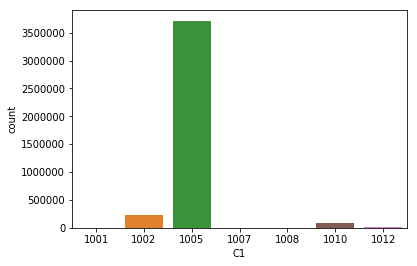

In [175]:
sns.countplot(x='C1', data=data)

In [176]:
data['C1'].value_counts(normalize=True)

1005    0.918592
1002    0.055042
1010    0.022292
1012    0.002820
1007    0.000867
1001    0.000241
1008    0.000146
Name: C1, dtype: float64

Result: Keep 1005, 1002, 1010, & collapse the rest into "other" group.

In [40]:
%%time

data['C1_n'] = 99
data.loc[data['C1'] == 1005, 'C1_n'] = 0
data.loc[data['C1'] == 1002, 'C1_n'] = 1
data.loc[data['C1'] == 1010, 'C1_n'] = 2

Wall time: 1.38 s


In [41]:
%%time

holdout_data['C1_n_h'] = 99
holdout_data.loc[holdout_data['C1'] == 1005, 'C1_n_h'] = 0
holdout_data.loc[holdout_data['C1'] == 1002, 'C1_n_h'] = 1
holdout_data.loc[holdout_data['C1'] == 1010, 'C1_n_h'] = 2

Wall time: 1.46 s


## C14

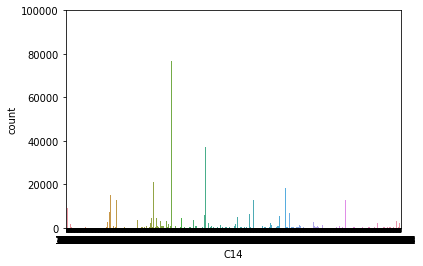

In [180]:
sns.countplot(x='C14', data=data)

In [707]:
data['C14'].value_counts(normalize=True)

4687     2.354748e-02
21611    2.249501e-02
21191    1.896809e-02
21189    1.888572e-02
19771    1.805661e-02
19772    1.791711e-02
16208    1.636550e-02
20108    1.462244e-02
8330     1.365482e-02
19950    1.302482e-02
15705    1.270228e-02
15701    1.249970e-02
15699    1.248412e-02
15707    1.247101e-02
15703    1.238939e-02
15708    1.238840e-02
15704    1.235748e-02
15702    1.194515e-02
15706    1.174950e-02
16615    1.086152e-02
23804    1.010711e-02
21768    9.241890e-03
21767    9.193657e-03
19251    8.419954e-03
22676    8.385573e-03
17239    8.380874e-03
17654    7.490917e-03
17653    7.468656e-03
6563     7.296008e-03
21790    6.927707e-03
             ...     
18555    2.473474e-07
22650    2.473474e-07
18534    2.473474e-07
18540    2.473474e-07
23261    2.473474e-07
23303    2.473474e-07
23338    2.473474e-07
21294    2.473474e-07
23590    2.473474e-07
23568    2.473474e-07
23581    2.473474e-07
23579    2.473474e-07
23554    2.473474e-07
11266    2.473474e-07
11267    2

Result: Keep 4687, 21611, 21191, 21189, 19771, 19772, 16208, 20108, 8330, 19950, 15705, 15701, 15699, 
15707, 15703, 15708, 15704, 15702, 15706, 16615, 23804, and collapse the rest into "other" group.

In [42]:
%%time

data['C14_n'] = 99
data.loc[data['C14'] == 4687, 'C14_n'] = 0
data.loc[data['C14'] == 21611, 'C14_n'] = 1
data.loc[data['C14'] == 21191, 'C14_n'] = 2
data.loc[data['C14'] == 21189, 'C14_n'] = 3
data.loc[data['C14'] == 19771, 'C14_n'] = 4
data.loc[data['C14'] == 19772, 'C14_n'] = 5
data.loc[data['C14'] == 16208, 'C14_n'] = 6
data.loc[data['C14'] == 20108, 'C14_n'] = 7
data.loc[data['C14'] == 8330, 'C14_n'] = 8
data.loc[data['C14'] == 19950, 'C14_n'] = 9
data.loc[data['C14'] == 15705, 'C14_n'] = 10
data.loc[data['C14'] == 15701, 'C14_n'] = 11
data.loc[data['C14'] == 15699, 'C14_n'] = 12
data.loc[data['C14'] == 15707, 'C14_n'] = 13
data.loc[data['C14'] == 15703, 'C14_n'] = 14
data.loc[data['C14'] == 15708, 'C14_n'] = 15
data.loc[data['C14'] == 15704, 'C14_n'] = 16
data.loc[data['C14'] == 15702, 'C14_n'] = 17
data.loc[data['C14'] == 15706, 'C14_n'] = 18
data.loc[data['C14'] == 16615, 'C14_n'] = 19
data.loc[data['C14'] == 23804, 'C14_n'] = 20

Wall time: 2.22 s


In [43]:
data['C14_n'].value_counts(normalize=True)

99    0.690507
0     0.023547
1     0.022495
2     0.018968
3     0.018886
4     0.018057
5     0.017917
6     0.016365
7     0.014622
8     0.013655
9     0.013025
10    0.012702
11    0.012500
12    0.012484
13    0.012471
14    0.012389
15    0.012388
16    0.012357
17    0.011945
18    0.011749
19    0.010862
20    0.010107
Name: C14_n, dtype: float64

In [616]:
holdout_data['C14'].value_counts(normalize=True)

23137    8.216252e-02
22104    2.729459e-02
22254    2.701518e-02
22261    2.667241e-02
22257    2.663462e-02
8330     2.129476e-02
24132    1.988219e-02
23161    1.679817e-02
23160    1.671275e-02
22676    1.324773e-02
21611    1.297684e-02
23139    1.246979e-02
23563    1.088703e-02
23141    1.057420e-02
21893    1.044159e-02
19771    9.893251e-03
19772    9.674134e-03
24152    8.710937e-03
17894    8.684285e-03
24107    8.329066e-03
17893    8.084171e-03
24320    7.719558e-03
24094    7.693780e-03
17239    7.629771e-03
24303    7.443204e-03
24304    7.358004e-03
24289    7.310161e-03
24155    7.044730e-03
24149    6.793500e-03
4687     6.561057e-03
             ...     
7649     2.184616e-07
15833    2.184616e-07
7647     2.184616e-07
24029    2.184616e-07
24024    2.184616e-07
24025    2.184616e-07
21600    2.184616e-07
21614    2.184616e-07
17157    2.184616e-07
18508    2.184616e-07
23447    2.184616e-07
24278    2.184616e-07
11192    2.184616e-07
23497    2.184616e-07
17222    2

Keep 23137, 22104, 22254, 22261, 22257, 8330, 24132, 23161, 23160, 22676, 21611, 23139, 23563, 23141, 21893, 19771, 19772, 24152, 17894, 24107, 17893, 24320, and the rest in the others group.

In [44]:
%%time

holdout_data['C14_n_h'] = 99
holdout_data.loc[holdout_data['C14'] == 23137, 'C14_n_h'] = 0
holdout_data.loc[holdout_data['C14'] == 22104, 'C14_n_h'] = 1
holdout_data.loc[holdout_data['C14'] == 22254, 'C14_n_h'] = 2
holdout_data.loc[holdout_data['C14'] == 22261, 'C14_n_h'] = 3
holdout_data.loc[holdout_data['C14'] == 22257, 'C14_n_h'] = 4
holdout_data.loc[holdout_data['C14'] == 8330, 'C14_n_h'] = 5
holdout_data.loc[holdout_data['C14'] == 24132, 'C14_n_h'] = 6
holdout_data.loc[holdout_data['C14'] == 23161, 'C14_n_h'] = 7
holdout_data.loc[holdout_data['C14'] == 22676, 'C14_n_h'] = 8
holdout_data.loc[holdout_data['C14'] == 21611, 'C14_n_h'] = 9
holdout_data.loc[holdout_data['C14'] == 23139, 'C14_n_h'] = 10
holdout_data.loc[holdout_data['C14'] == 23563, 'C14_n_h'] = 11
holdout_data.loc[holdout_data['C14'] == 23141, 'C14_n_h'] = 12
holdout_data.loc[holdout_data['C14'] == 21893, 'C14_n_h'] = 13
holdout_data.loc[holdout_data['C14'] == 19771, 'C14_n_h'] = 14
holdout_data.loc[holdout_data['C14'] == 19772, 'C14_n_h'] = 15
holdout_data.loc[holdout_data['C14'] == 24152, 'C14_n_h'] = 16
holdout_data.loc[holdout_data['C14'] == 17894, 'C14_n_h'] = 17
holdout_data.loc[holdout_data['C14'] == 24107, 'C14_n_h'] = 18
holdout_data.loc[holdout_data['C14'] == 17893, 'C14_n_h'] = 19
holdout_data.loc[holdout_data['C14'] == 24320, 'C14_n_h'] = 20

Wall time: 4.09 s


In [703]:
holdout_data['C14_n_h'].value_counts(normalize=True)

99    0.620553
0     0.082163
1     0.027295
2     0.027015
3     0.026672
4     0.026635
5     0.021295
6     0.019882
7     0.016798
8     0.013248
9     0.012977
10    0.012470
11    0.010887
12    0.010574
13    0.010442
14    0.009893
15    0.009674
16    0.008711
17    0.008684
18    0.008329
19    0.008084
20    0.007720
Name: C14_n_h, dtype: float64

## C15

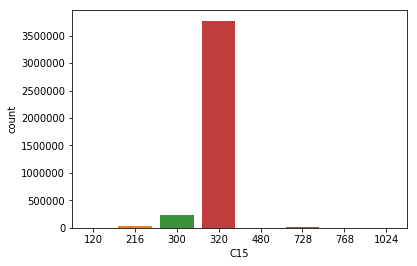

In [189]:
sns.countplot(x='C15', data=data)

In [190]:
data['C15'].value_counts(normalize=True)

320     0.932685
300     0.057873
216     0.007362
728     0.001833
120     0.000084
1024    0.000067
480     0.000057
768     0.000039
Name: C15, dtype: float64

Result: Keep 320,300, and collapse the rest into "other" group.

In [45]:
%%time

data['C15_n'] = 99
data.loc[data['C15'] == 320, 'C15_n'] = 0
data.loc[data['C15'] == 300, 'C15_n'] = 1

Wall time: 1.26 s


In [46]:
%%time

holdout_data['C15_n_h'] = 99
holdout_data.loc[holdout_data['C15'] == 320, 'C15_n_h'] = 0
holdout_data.loc[holdout_data['C15'] == 300, 'C15_n_h'] = 1

Wall time: 1.38 s


## C16

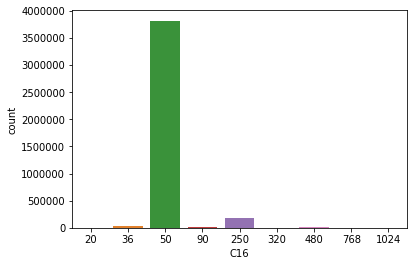

In [194]:
sns.countplot(x='C16', data=data)

In [398]:
data['C16'].value_counts(normalize=True)

50      0.943367
250     0.044623
36      0.007362
480     0.002568
90      0.001833
20      0.000084
768     0.000067
320     0.000057
1024    0.000039
Name: C16, dtype: float64

Result: Keep 50,and collapse the rest into "other" group.

In [47]:
%%time

data['C16_n'] = 99
data.loc[data['C16'] == 50, 'C16_n'] = 0

Wall time: 1.15 s


In [48]:
%%time

holdout_data['C16_n_h'] = 99
holdout_data.loc[holdout_data['C16'] == 50, 'C16_n_h'] = 0

Wall time: 1.42 s


## C17

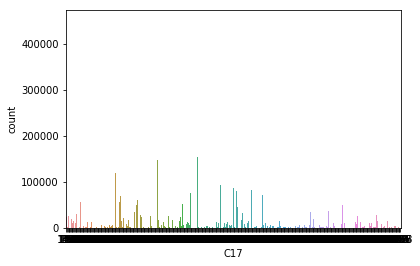

In [64]:
sns.countplot(x='C17', data=data)

In [200]:
data['C17'].value_counts(normalize=True)

1722    1.114058e-01
2424    3.785381e-02
2227    3.630986e-02
1800    2.946799e-02
423     2.354748e-02
2480    2.278342e-02
2502    2.117863e-02
2528    2.038514e-02
2506    1.974748e-02
2374    1.875685e-02
2545    1.754114e-02
1872    1.723715e-02
1994    1.495957e-02
2526    1.466300e-02
2299    1.462244e-02
1863    1.407555e-02
761     1.375549e-02
2333    1.270574e-02
1993    1.230009e-02
2665    1.200006e-02
2676    1.182420e-02
1873    1.166441e-02
2507    1.108908e-02
2726    1.010711e-02
2647    9.037334e-03
2566    8.954472e-03
2667    8.801859e-03
2201    8.419954e-03
2616    8.385573e-03
1973    8.380874e-03
            ...     
2605    6.925728e-06
2687    6.431034e-06
2501    6.183686e-06
2582    5.688991e-06
2593    4.946949e-06
2390    4.699601e-06
2568    3.710212e-06
2459    3.215517e-06
872     3.215517e-06
2598    3.215517e-06
1515    3.215517e-06
2719    2.968169e-06
2678    2.473474e-06
2737    2.226127e-06
2651    2.226127e-06
2511    1.978780e-06
2084    1.978

Result: Keep 1722, 2424, 2227, 1800, 423, 2480, 2502, 2528, 2506, 2374, 2545, 1872, 1994, 2526, 2299, 1863, 761, 2333, 1993,
2665, 2676, 1873, 2507, 2726,and collapse the rest into "other" group.

In [49]:
%%time

data['C17_n'] = 99
data.loc[data['C17'] == 1722, 'C17_n'] = 0
data.loc[data['C17'] == 2424, 'C17_n'] = 1
data.loc[data['C17'] == 2227, 'C17_n'] = 2
data.loc[data['C17'] == 1800, 'C17_n'] = 3
data.loc[data['C17'] == 423, 'C17_n'] = 4
data.loc[data['C17'] == 2480, 'C17_n'] = 5
data.loc[data['C17'] == 2502, 'C17_n'] = 6
data.loc[data['C17'] == 2528, 'C17_n'] = 7
data.loc[data['C17'] == 2506, 'C17_n'] = 8
data.loc[data['C17'] == 2374, 'C17_n'] = 9
data.loc[data['C17'] == 2545, 'C17_n'] = 10
data.loc[data['C17'] == 1872, 'C17_n'] = 11
data.loc[data['C17'] == 1994, 'C17_n'] = 12
data.loc[data['C17'] == 2526, 'C17_n'] = 13
data.loc[data['C17'] == 2299, 'C17_n'] = 14
data.loc[data['C17'] == 1863, 'C17_n'] = 15
data.loc[data['C17'] == 761, 'C17_n'] = 16
data.loc[data['C17'] == 2333, 'C17_n'] = 17
data.loc[data['C17'] == 1993, 'C17_n'] = 18
data.loc[data['C17'] == 2665, 'C17_n'] = 19
data.loc[data['C17'] == 2676, 'C17_n'] = 20
data.loc[data['C17'] == 1873, 'C17_n'] = 21
data.loc[data['C17'] == 2507, 'C17_n'] = 22
data.loc[data['C17'] == 2726, 'C17_n'] = 23

Wall time: 2.37 s


In [50]:
data.C17_n.head()

id
10001264480619467364    99
10004482643316086592    99
10005951398749600249     0
10007164336863914220     0
10009635774586344851    17
Name: C17_n, dtype: int64

In [613]:
holdout_data['C17'].value_counts(normalize=True)

2545    1.076168e-01
2664    1.052065e-01
2761    4.464393e-02
2676    3.660739e-02
2667    3.351091e-02
2763    2.566377e-02
1722    2.141448e-02
761     2.129716e-02
2772    2.077744e-02
2768    1.988219e-02
2227    1.963183e-02
2480    1.908327e-02
2771    1.908284e-02
2788    1.774520e-02
2039    1.676846e-02
2717    1.639554e-02
2716    1.363353e-02
2616    1.324773e-02
2701    1.324423e-02
1994    1.295652e-02
2526    1.046344e-02
1993    9.893469e-03
2770    9.580414e-03
2624    9.056980e-03
2374    8.676638e-03
2764    8.329066e-03
2774    8.279475e-03
2556    8.215248e-03
2528    8.159758e-03
2790    7.952438e-03
            ...     
2689    1.485539e-05
1008    1.463693e-05
2509    1.354462e-05
2551    1.288923e-05
2339    1.267077e-05
1972    1.092308e-05
832     8.520001e-06
1141    8.301540e-06
2567    8.083078e-06
1149    7.427694e-06
2722    6.990770e-06
2483    5.898463e-06
1107    5.898463e-06
2612    3.713847e-06
549     3.058462e-06
2705    3.058462e-06
2479    2.840

Keep 2545, 2664, 2761, 2676, 2667, 2763, 1722, 761, 2772, 2768, 2227, 2480, 2771, 2788, 2039, 2717, 2716, 2616, 2701, 1994,  2526, 1993, 2770, 2624, 2374, and the rest into the "other" group.

In [51]:
%%time

holdout_data['C17_n_h'] = 99
holdout_data.loc[holdout_data['C17'] == 2545, 'C17_n_h'] = 0
holdout_data.loc[holdout_data['C17'] == 2664, 'C17_n_h'] = 1
holdout_data.loc[holdout_data['C17'] == 2761, 'C17_n_h'] = 2
holdout_data.loc[holdout_data['C17'] == 2676, 'C17_n_h'] = 3
holdout_data.loc[holdout_data['C17'] == 2763, 'C17_n_h'] = 4
holdout_data.loc[holdout_data['C17'] == 1722, 'C17_n_h'] = 5
holdout_data.loc[holdout_data['C17'] == 761, 'C17_n_h'] = 6
holdout_data.loc[holdout_data['C17'] == 2772, 'C17_n_h'] = 7
holdout_data.loc[holdout_data['C17'] == 2768, 'C17_n_h'] = 8
holdout_data.loc[holdout_data['C17'] == 2227, 'C17_n_h'] = 9
holdout_data.loc[holdout_data['C17'] == 2480, 'C17_n_h'] = 10
holdout_data.loc[holdout_data['C17'] == 2771, 'C17_n_h'] = 11
holdout_data.loc[holdout_data['C17'] == 2788, 'C17_n_h'] = 12
holdout_data.loc[holdout_data['C17'] == 2039, 'C17_n_h'] = 13
holdout_data.loc[holdout_data['C17'] == 2717, 'C17_n_h'] = 14
holdout_data.loc[holdout_data['C17'] == 2716, 'C17_n_h'] = 15
holdout_data.loc[holdout_data['C17'] == 2616, 'C17_n_h'] = 16
holdout_data.loc[holdout_data['C17'] == 2701, 'C17_n_h'] = 17
holdout_data.loc[holdout_data['C17'] == 1994, 'C17_n_h'] = 18
holdout_data.loc[holdout_data['C17'] == 2526, 'C17_n_h'] = 19
holdout_data.loc[holdout_data['C17'] == 1993, 'C17_n_h'] = 20
holdout_data.loc[holdout_data['C17'] == 2770, 'C17_n_h'] = 21
holdout_data.loc[holdout_data['C17'] == 2624, 'C17_n_h'] = 22
holdout_data.loc[holdout_data['C17'] == 2374, 'C17_n_h'] = 23

Wall time: 4.52 s


## C18

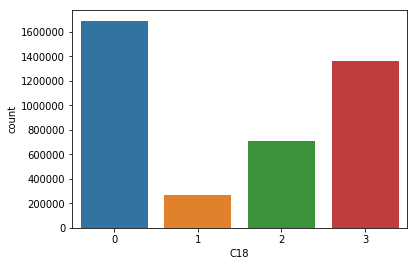

In [203]:
sns.countplot(x='C18', data=data)

In [204]:
data['C18'].value_counts(normalize=True)

0    0.418628
3    0.337813
2    0.176376
1    0.067183
Name: C18, dtype: float64

Result: Keep all.

## C19

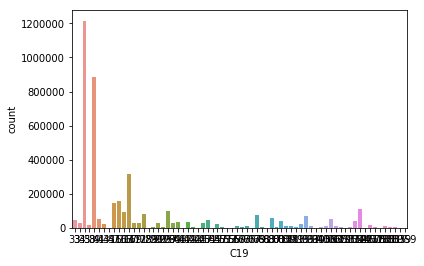

In [557]:
sns.countplot(x='C19', data=data)

In [206]:
data['C19'].value_counts(normalize=True)

35      3.006864e-01
39      2.186940e-01
167     7.786201e-02
161     3.925354e-02
47      3.591040e-02
1327    2.712907e-02
297     2.509488e-02
163     2.281459e-02
175     1.999705e-02
679     1.817979e-02
935     1.738976e-02
687     1.380619e-02
1063    1.297758e-02
41      1.271242e-02
33      1.182321e-02
431     1.060824e-02
803     1.010711e-02
1319    9.797432e-03
303     8.105081e-03
419     8.054128e-03
171     7.620280e-03
169     7.261379e-03
299     7.251980e-03
427     6.628664e-03
34      6.466157e-03
291     6.360045e-03
547     6.114924e-03
43      5.297935e-03
815     5.129491e-03
38      4.522748e-03
            ...     
559     2.092312e-03
813     1.514508e-03
551     1.291648e-03
681     1.201614e-03
290     1.121968e-03
1315    9.767751e-04
801     7.202758e-04
295     6.896047e-04
673     6.017963e-04
1831    5.854714e-04
423     5.679097e-04
1071    5.317970e-04
1835    4.776279e-04
1575    4.729283e-04
943     4.719389e-04
425     4.291478e-04
1839    2.876

Result: Keep 35, 39, 167, 161, 47, 1327, 297, 163, 175, 679, 935, 687, 1063, 41, 33, 431, 803, and collapse the rest into "other" group.

In [52]:
%%time

data['C19_n'] = 99
data.loc[data['C19'] == 35, 'C19_n'] = 0
data.loc[data['C19'] == 39, 'C19_n'] = 1
data.loc[data['C19'] == 167, 'C19_n'] = 2
data.loc[data['C19'] == 161, 'C19_n'] = 3
data.loc[data['C19'] == 47, 'C19_n'] = 4
data.loc[data['C19'] == 1327, 'C19_n'] = 5
data.loc[data['C19'] == 297, 'C19_n'] = 6
data.loc[data['C19'] == 163, 'C19_n'] = 7
data.loc[data['C19'] == 175, 'C19_n'] = 8
data.loc[data['C19'] == 679, 'C19_n'] = 9
data.loc[data['C19'] == 935, 'C19_n'] = 10
data.loc[data['C19'] == 687, 'C19_n'] = 11
data.loc[data['C19'] == 1063, 'C19_n'] = 12
data.loc[data['C19'] == 41, 'C19_n'] = 13
data.loc[data['C19'] == 33, 'C19_n'] = 14
data.loc[data['C19'] == 431, 'C19_n'] = 15
data.loc[data['C19'] == 803, 'C19_n'] = 16

Wall time: 2.18 s


In [697]:
data['C19_n'].value_counts(normalize=True)

0     0.300686
1     0.218694
99    0.124954
2     0.077862
3     0.039254
4     0.035910
5     0.027129
6     0.025095
7     0.022815
8     0.019997
9     0.018180
10    0.017390
11    0.013806
12    0.012978
13    0.012712
14    0.011823
15    0.010608
16    0.010107
Name: C19_n, dtype: float64

In [607]:
holdout_data['C19'].value_counts(normalize=True)

35      3.326436e-01
39      1.864943e-01
431     1.076168e-01
299     5.910347e-02
167     5.440545e-02
47      3.939867e-02
175     3.205530e-02
33      3.132018e-02
935     1.652837e-02
295     1.561738e-02
163     1.489405e-02
41      1.253664e-02
425     1.205886e-02
171     1.074197e-02
1063    9.893469e-03
1327    8.519346e-03
161     8.402251e-03
291     5.894312e-03
815     4.859022e-03
43      4.727727e-03
943     3.520071e-03
687     2.866434e-03
427     2.651250e-03
303     2.448736e-03
937     2.096357e-03
169     1.942779e-03
1583    1.638025e-03
813     1.609406e-03
1071    1.399683e-03
559     1.354243e-03
809     1.349437e-03
681     1.183406e-03
297     1.129665e-03
1059    9.103294e-04
801     8.725355e-04
1831    8.334309e-04
1315    7.844955e-04
1575    7.132770e-04
673     6.486124e-04
1319    6.258924e-04
289     6.256740e-04
939     4.201016e-04
555     4.107078e-04
1199    1.872216e-04
1451    5.308616e-05
553     1.354462e-05
677     4.369232e-07
Name: C19, dt

Keep 35, 39, 431, 299, 167, 47, 175, 33, 935, 295, 163, 41, 425, 171, 1063, 1327, 161, and put the rest in other group.

In [53]:
%%time

holdout_data['C19_n_h'] = 99
holdout_data.loc[holdout_data['C19'] == 35, 'C19_n_h'] = 0
holdout_data.loc[holdout_data['C19'] == 39, 'C19_n_h'] = 1
holdout_data.loc[holdout_data['C19'] == 431, 'C19_n_h'] = 2
holdout_data.loc[holdout_data['C19'] == 299, 'C19_n_h'] = 3
holdout_data.loc[holdout_data['C19'] == 167, 'C19_n_h'] = 4
holdout_data.loc[holdout_data['C19'] == 47, 'C19_n_h'] = 5
holdout_data.loc[holdout_data['C19'] == 175, 'C19_n_h'] = 6
holdout_data.loc[holdout_data['C19'] == 33, 'C19_n_h'] = 7
holdout_data.loc[holdout_data['C19'] == 935, 'C19_n_h'] = 8
holdout_data.loc[holdout_data['C19'] == 295, 'C19_n_h'] = 9
holdout_data.loc[holdout_data['C19'] == 163, 'C19_n_h'] = 10
holdout_data.loc[holdout_data['C19'] == 41, 'C19_n_h'] = 11
holdout_data.loc[holdout_data['C19'] == 425, 'C19_n_h'] = 12
holdout_data.loc[holdout_data['C19'] == 171, 'C19_n_h'] = 13
holdout_data.loc[holdout_data['C19'] == 1063, 'C19_n_h'] = 14
holdout_data.loc[holdout_data['C19'] == 1327, 'C19_n_h'] = 15
holdout_data.loc[holdout_data['C19'] == 161, 'C19_n_h'] = 16

Wall time: 4.1 s


In [695]:
holdout_data['C19_n_h'].value_counts(normalize=True)

0     0.332644
1     0.186494
2     0.107617
3     0.059103
4     0.054405
99    0.047770
5     0.039399
6     0.032055
7     0.031320
8     0.016528
9     0.015617
10    0.014894
11    0.012537
12    0.012059
13    0.010742
14    0.009893
15    0.008519
16    0.008402
Name: C19_n_h, dtype: float64

## C20

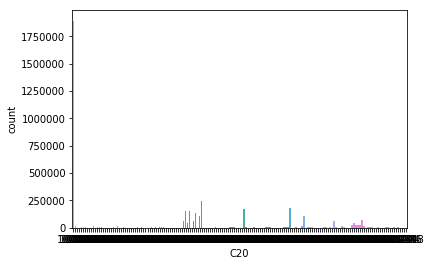

In [300]:
sns.countplot(x='C20', data=data)

In [211]:
data['C20'].value_counts(normalize=True)

-1         4.682960e-01
 100084    6.039458e-02
 100148    4.443077e-02
 100111    4.253263e-02
 100077    3.904206e-02
 100075    3.826984e-02
 100081    3.304092e-02
 100083    2.646296e-02
 100156    2.557350e-02
 100193    1.744566e-02
 100176    1.612186e-02
 100074    1.451707e-02
 100079    1.430015e-02
 100189    1.174233e-02
 100076    1.132159e-02
 100192    5.826269e-03
 100190    5.589063e-03
 100191    5.545777e-03
 100188    5.443375e-03
 100013    4.915783e-03
 100031    4.654584e-03
 100155    4.008513e-03
 100194    3.617704e-03
 100181    3.533358e-03
 100000    3.401275e-03
 100233    2.914000e-03
 100105    2.913011e-03
 100182    2.885061e-03
 100003    2.850185e-03
 100119    2.838807e-03
               ...     
 100121    5.293235e-05
 100229    5.268501e-05
 100073    4.674867e-05
 100224    4.551193e-05
 100099    3.487599e-05
 100043    3.462864e-05
 100244    3.017639e-05
 100163    2.671352e-05
 100010    2.424005e-05
 100178    2.300331e-05
 100213    2.028

Result: Keep -1, 100084, 100148, 100111, 100077, 100075, 100081, 100083, 100156, 100193, 100176, 100074, 100079, 100189, 100076, and collapse the rest into "other" group.

In [54]:
%%time

data['C20_n'] = 99
data.loc[data['C20'] == -1, 'C20_n'] = 0
data.loc[data['C20'] == 100084, 'C20_n'] = 1
data.loc[data['C20'] == 100148, 'C20_n'] = 2
data.loc[data['C20'] == 100111, 'C20_n'] = 3
data.loc[data['C20'] == 100077, 'C20_n'] = 4
data.loc[data['C20'] == 100075, 'C20_n'] = 5
data.loc[data['C20'] == 100081, 'C20_n'] = 6
data.loc[data['C20'] == 100083, 'C20_n'] = 7
data.loc[data['C20'] == 100156, 'C20_n'] = 8
data.loc[data['C20'] == 100193, 'C20_n'] = 9
data.loc[data['C20'] == 100176, 'C20_n'] = 10
data.loc[data['C20'] == 100074, 'C20_n'] = 11
data.loc[data['C20'] == 100079, 'C20_n'] = 12
data.loc[data['C20'] == 100189, 'C20_n'] = 13
data.loc[data['C20'] == 100076, 'C20_n'] = 14

Wall time: 2.16 s


In [595]:
data[['C20','C20_n']].head()

,C20,C20_n
id,,
10001264480619467364,100191,99
10004482643316086592,100088,99
10005951398749600249,-1,0
10007164336863914220,-1,0
10009635774586344851,-1,0


In [585]:
holdout_data['C20'].value_counts(normalize=True)

-1         4.659220e-01
 100084    9.603352e-02
 100148    6.948236e-02
 100176    3.486843e-02
 100075    3.146196e-02
 100111    2.825451e-02
 100081    2.439145e-02
 100077    2.411160e-02
 100083    2.123578e-02
 100189    1.368247e-02
 100193    1.179430e-02
 100188    1.103275e-02
 100074    1.002608e-02
 100079    9.954857e-03
 100194    9.742076e-03
 100160    8.047032e-03
 100156    7.787281e-03
 100192    7.357130e-03
 100013    6.917367e-03
 100076    6.592515e-03
 100161    5.911570e-03
 100177    5.563124e-03
 100170    5.282838e-03
 100000    4.969127e-03
 100202    4.647770e-03
 100101    4.607355e-03
 100199    4.516038e-03
 100200    4.280318e-03
 100105    4.186161e-03
 100182    3.505216e-03
               ...     
 100162    1.572923e-05
 100179    1.529231e-05
 100139    1.463693e-05
 100229    1.376308e-05
 100215    1.354462e-05
 100244    1.245231e-05
 100087    1.201539e-05
 100010    1.048616e-05
 100091    9.830771e-06
 100054    9.612309e-06
 100109    9.393

Keep -1, 100084, 100148, 100176, 100075, 100111, 100081, 100077, 100083, 100189, 100193, 100188, 100074, 100079, 100194, 100160,  and collapse the rest in one group.

In [55]:
%%time

holdout_data['C20_n_h'] = 99
holdout_data.loc[holdout_data['C20'] == -1, 'C20_n_h'] = 0
holdout_data.loc[holdout_data['C20'] == 100084, 'C20_n_h'] = 1
holdout_data.loc[holdout_data['C20'] == 100148, 'C20_n_h'] = 2
holdout_data.loc[holdout_data['C20'] == 100075, 'C20_n_h'] = 3
holdout_data.loc[holdout_data['C20'] == 100111, 'C20_n_h'] = 4
holdout_data.loc[holdout_data['C20'] == 100081, 'C20_n_h'] = 5
holdout_data.loc[holdout_data['C20'] == 100077, 'C20_n_h'] = 6
holdout_data.loc[holdout_data['C20'] == 100083, 'C20_n_h'] = 7
holdout_data.loc[holdout_data['C20'] == 100189, 'C20_n_h'] = 8
holdout_data.loc[holdout_data['C20'] == 100193, 'C20_n_h'] = 9
holdout_data.loc[holdout_data['C20'] == 100188, 'C20_n_h'] = 10
holdout_data.loc[holdout_data['C20'] == 100074, 'C20_n_h'] = 11
holdout_data.loc[holdout_data['C20'] == 100079, 'C20_n_h'] = 12
holdout_data.loc[holdout_data['C20'] == 100194, 'C20_n_h'] = 13
holdout_data.loc[holdout_data['C20'] == 100160, 'C20_n_h'] = 14

Wall time: 3.06 s


## C21

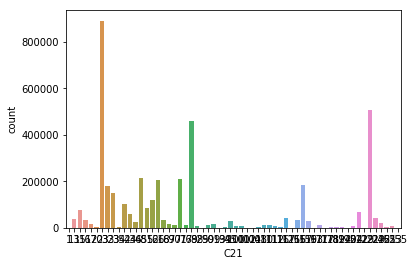

In [214]:
sns.countplot(x='C21', data=data)

In [215]:
data['C21'].value_counts(normalize=True)

23     0.220149
221    0.124941
79     0.113871
48     0.053414
71     0.052013
61     0.050800
157    0.045848
32     0.044255
33     0.037065
52     0.029857
42     0.025213
51     0.020973
15     0.018987
212    0.016362
43     0.014618
117    0.010389
229    0.010107
13     0.009482
16     0.008677
156    0.008223
68     0.008012
159    0.007191
95     0.006830
46     0.005821
246    0.004911
69     0.004374
91     0.004207
17     0.004121
111    0.003467
76     0.003414
70     0.003295
90     0.003177
110    0.003031
171    0.002872
204    0.002306
101    0.002004
253    0.001955
112    0.001842
82     0.001732
100    0.001634
182    0.001253
178    0.001224
35     0.001178
108    0.001158
94     0.000561
251    0.000527
116    0.000390
194    0.000355
20     0.000335
93     0.000313
102    0.000213
104    0.000212
126    0.000197
163    0.000170
177    0.000138
255    0.000114
195    0.000089
1      0.000082
219    0.000039
85     0.000014
Name: C21, dtype: float64

In [580]:
holdout_data['C21'].value_counts(normalize=True)

23     2.174355e-01
221    2.111807e-01
51     1.370702e-01
13     7.215109e-02
79     5.839391e-02
71     4.989073e-02
61     4.854653e-02
240    4.298603e-02
33     3.122493e-02
32     3.104929e-02
48     2.277025e-02
52     1.793591e-02
16     1.031816e-02
246    1.023558e-02
42     8.156918e-03
204    4.072779e-03
95     3.793585e-03
171    3.184733e-03
46     2.962776e-03
76     2.232896e-03
253    1.905640e-03
101    1.846000e-03
251    1.434200e-03
82     1.240643e-03
90     1.168114e-03
100    1.120271e-03
94     1.036382e-03
91     9.677848e-04
68     9.103294e-04
15     8.417325e-04
17     4.688185e-04
102    4.107078e-04
70     3.012585e-04
116    2.739508e-04
255    2.357200e-04
112    1.826339e-04
219    6.029540e-05
194    2.840000e-06
184    2.184616e-07
Name: C21, dtype: float64

Result: Keep  23, 221, 79, 48, 71, 61, 157, 32, 33, 52, 42, 51, 15, 212, 43, 117, 229, and collapse the rest into "other" group.

In [56]:
%%time

data['C21_n'] = 99
data.loc[data['C21'] == 23, 'C21_n'] = 0
data.loc[data['C21'] == 221, 'C21_n'] = 1
data.loc[data['C21'] == 79, 'C21_n'] = 2
data.loc[data['C21'] == 48, 'C21_n'] = 3
data.loc[data['C21'] == 71, 'C21_n'] = 4
data.loc[data['C21'] == 61, 'C21_n'] = 5
data.loc[data['C21'] == 157, 'C21_n'] = 6
data.loc[data['C21'] == 32, 'C21_n'] = 7
data.loc[data['C21'] == 33, 'C21_n'] = 8
data.loc[data['C21'] == 52, 'C21_n'] = 9
data.loc[data['C21'] == 42, 'C21_n'] = 10
data.loc[data['C21'] == 51, 'C21_n'] = 11
data.loc[data['C21'] == 15, 'C21_n'] = 12
data.loc[data['C21'] == 212, 'C21_n'] = 13
data.loc[data['C21'] == 43, 'C21_n'] = 14
data.loc[data['C21'] == 117, 'C21_n'] = 15
data.loc[data['C21'] == 229, 'C21_n'] = 16

Wall time: 2.9 s


Result: Keep  23, 221, 51, 13, 79, 71, 61, 240, 33, 32, 48, 52, 16, 246, 42, 204, 95, 171, 46, 76, 253, 101, 251, 82, 90, 100,  94, and collapse the rest into "other" group.

In [57]:
%%time

holdout_data['C21_n_h'] = 99
holdout_data.loc[holdout_data['C21'] == 23, 'C21_n_h'] = 0
holdout_data.loc[holdout_data['C21'] == 221, 'C21_n_h'] = 1
holdout_data.loc[holdout_data['C21'] == 51, 'C21_n_h'] = 2
holdout_data.loc[holdout_data['C21'] == 13, 'C21_n_h'] = 3
holdout_data.loc[holdout_data['C21'] == 79, 'C21_n_h'] = 4
holdout_data.loc[holdout_data['C21'] == 71, 'C21_n_h'] = 5
holdout_data.loc[holdout_data['C21'] == 61, 'C21_n_h'] = 6
holdout_data.loc[holdout_data['C21'] == 240, 'C21_n_h'] = 7
holdout_data.loc[holdout_data['C21'] == 33, 'C21_n_h'] = 8
holdout_data.loc[holdout_data['C21'] == 32, 'C21_n_h'] = 9
holdout_data.loc[holdout_data['C21'] == 48, 'C21_n_h'] = 10
holdout_data.loc[holdout_data['C21'] == 52, 'C21_n_h'] = 11
holdout_data.loc[holdout_data['C21'] == 16, 'C21_n_h'] = 12
holdout_data.loc[holdout_data['C21'] == 246, 'C21_n_h'] = 13
holdout_data.loc[holdout_data['C21'] == 42, 'C21_n_h'] = 14
holdout_data.loc[holdout_data['C21'] == 204, 'C21_n_h'] = 15
holdout_data.loc[holdout_data['C21'] == 95, 'C21_n_h'] = 16

Wall time: 3.32 s


In [124]:
data.head()

,click,hour,C1,site_category,app_category,device_id,device_conn_type,C14,C15,C16,...,C18,C19,C20,C21,banner_pos_n,site_id_n,site_domain_n,app_id_n,app_domain_n,device_model_n
id,,,,,,,,,,,,,,,,,,,,,
10001264480619467364,0,2014-01-21 00:10:00,1002,50e219e0,07d7df22,c357dbff,0,21689,320,50,...,3,167,100191,23,0,99,99,0,0,99
10004482643316086592,0,2014-01-21 00:10:00,1005,50e219e0,cef3e649,a99f214a,0,21234,320,50,...,3,163,100088,61,0,0,99,99,5,99
10005951398749600249,0,2014-01-21 00:10:00,1005,28905ebd,07d7df22,a99f214a,0,15706,320,50,...,0,35,-1,79,0,1,99,0,0,99
10007164336863914220,1,2014-01-21 00:10:00,1005,28905ebd,07d7df22,a99f214a,0,15706,320,50,...,0,35,-1,79,0,1,99,0,0,99
10009635774586344851,0,2014-01-21 00:10:00,1005,3e814130,07d7df22,a99f214a,0,20352,320,50,...,0,39,-1,157,0,99,99,0,0,99


<a id='3'></a>
### Create Dummy Variables

In [58]:
%%time

banner_pos_n = pd.get_dummies(data['banner_pos_n'],drop_first=True,prefix='bs')
site_category_n = pd.get_dummies(data['site_category_n'],drop_first=True, prefix='sc')
app_category_n = pd.get_dummies(data['app_category_n'],drop_first=True, prefix='ac')
device_type_n = pd.get_dummies(data['device_type_n'],drop_first=True, prefix='dt')
device_con_type_n = pd.get_dummies(data['device_conn_type'],drop_first=True, prefix='dct')
site_id_n = pd.get_dummies(data['site_id_n'],drop_first=True, prefix='s_id')
site_domain_n = pd.get_dummies(data['site_domain_n'],drop_first=True, prefix='s_dom')
app_id_n = pd.get_dummies(data['app_id_n'],drop_first=True, prefix='app_id')
device_model_n = pd.get_dummies(data['device_model_n'],drop_first=True, prefix='dev_mod')
app_domain_n = pd.get_dummies(data['app_domain_n'],drop_first=True, prefix='app_dom')
C1_n = pd.get_dummies(data['C1_n'],drop_first=True, prefix='C1')
C14_n = pd.get_dummies(data['C14_n'],drop_first=True, prefix='C14')
C15_n = pd.get_dummies(data['C15_n'],drop_first=True, prefix='C15')
C16_n = pd.get_dummies(data['C16_n'],drop_first=True, prefix='C16')
C17_n = pd.get_dummies(data['C17_n'],drop_first=True, prefix='C17')
C18_n = pd.get_dummies(data['C18'],drop_first=True, prefix='C18')
C19_n = pd.get_dummies(data['C19_n'],drop_first=True, prefix='C19')
C20_n = pd.get_dummies(data['C20_n'],drop_first=True, prefix='C20')
C21_n = pd.get_dummies(data['C21_n'],drop_first=True, prefix='C21')

Wall time: 3.56 s


In [ ]:
%%time

banner_pos_n = pd.get_dummies(data_1['banner_pos_n'],drop_first=True,prefix='bs')
site_category_n = pd.get_dummies(data_1['site_category_n'],drop_first=True, prefix='sc')
app_category_n = pd.get_dummies(data_1['app_category_n'],drop_first=True, prefix='ac')
device_type_n = pd.get_dummies(data_1['device_type_n'],drop_first=True, prefix='dt')
device_conn_type_n = pd.get_dummies(data_1['device_conn_type'],drop_first=True, prefix='dct')

In [59]:
%%time

banner_pos_n_h = pd.get_dummies(holdout_data['banner_pos_n_h'],drop_first=True,prefix='bs')
site_category_n_h = pd.get_dummies(holdout_data['site_category_n_h'],drop_first=True, prefix='sc')
app_category_n_h = pd.get_dummies(holdout_data['app_category_n_h'],drop_first=True, prefix='ac')
device_type_n_h = pd.get_dummies(holdout_data['device_type_n_h'],drop_first=True, prefix='dt')
device_con_type_n_h = pd.get_dummies(holdout_data['device_conn_type'],drop_first=True, prefix='dct')
site_id_n_h = pd.get_dummies(holdout_data['site_id_n_h'],drop_first=True, prefix='s_id')
site_domain_n_h = pd.get_dummies(holdout_data['site_domain_n_h'],drop_first=True, prefix='s_dom')
app_id_n_h = pd.get_dummies(holdout_data['app_id_n_h'],drop_first=True, prefix='app_id')
device_model_n_h = pd.get_dummies(holdout_data['device_model_n_h'],drop_first=True, prefix='dev_mod')
app_domain_n_h = pd.get_dummies(holdout_data['app_domain_n_h'],drop_first=True, prefix='app_dom')
C1_n_h = pd.get_dummies(holdout_data['C1_n_h'],drop_first=True, prefix='C1')
C14_n_h = pd.get_dummies(holdout_data['C14_n_h'],drop_first=True, prefix='C14')
C15_n_h = pd.get_dummies(holdout_data['C15_n_h'],drop_first=True, prefix='C15')
C16_n_h = pd.get_dummies(holdout_data['C16_n_h'],drop_first=True, prefix='C16')
C17_n_h = pd.get_dummies(holdout_data['C17_n_h'],drop_first=True, prefix='C17')
C18_n_h = pd.get_dummies(holdout_data['C18'],drop_first=True, prefix='C18')
C19_n_h = pd.get_dummies(holdout_data['C19_n_h'],drop_first=True, prefix='C19')
C20_n_h = pd.get_dummies(holdout_data['C20_n_h'],drop_first=True, prefix='C20')
C21_n_h = pd.get_dummies(holdout_data['C21_n_h'],drop_first=True, prefix='C21')

Wall time: 4.77 s


In [68]:
banner_pos_n_h.shape

(4577464, 2)

In [69]:
banner_pos_n.shape

(4042896, 2)

In [70]:
site_category_n_h.shape

(4577464, 9)

In [71]:
site_category_n.shape

(4042896, 9)

In [72]:
app_category_n_h.shape

(4577464, 8)

In [73]:
app_category_n.shape

(4042896, 8)

In [74]:
device_type_n_h.shape

(4577464, 3)

In [75]:
device_type_n.shape

(4042896, 3)

In [76]:
device_con_type_n_h.shape

(4577464, 3)

In [77]:
device_con_type_n.shape

(4042896, 3)

In [78]:
site_id_n_h.shape

(4577464, 8)

In [79]:
site_id_n.shape

(4042896, 8)

In [80]:
site_domain_n_h.shape

(4577464, 7)

In [81]:
site_domain_n.shape

(4042896, 7)

In [82]:
app_id_n_h.shape

(4577464, 9)

In [83]:
app_id_n.shape

(4042896, 9)

In [84]:
device_model_n_h.shape

(4577464, 14)

In [85]:
device_model_n.shape

(4042896, 14)

In [86]:
app_domain_n_h.shape

(4577464, 9)

In [87]:
app_domain_n.shape

(4042896, 9)

In [88]:
C1_n_h.shape

(4577464, 3)

In [89]:
C14_n_h.shape

(4577464, 21)

In [90]:
C14_n.shape

(4042896, 21)

In [91]:
C15_n_h.shape

(4577464, 2)

In [92]:
C15_n.shape

(4042896, 2)

In [93]:
C16_n_h.shape

(4577464, 1)

In [94]:
C16_n.shape

(4042896, 1)

In [95]:
C17_n_h.shape

(4577464, 24)

In [96]:
C17_n.shape

(4042896, 24)

In [97]:
C18_n_h.shape

(4577464, 3)

In [98]:
C18_n.shape

(4042896, 3)

In [99]:
C19_n_h.shape

(4577464, 17)

In [100]:
C19_n.shape

(4042896, 17)

In [101]:
C20_n_h.shape

(4577464, 15)

In [102]:
C20_n.shape

(4042896, 15)

In [103]:
C21_n_h.shape

(4577464, 17)

In [104]:
C21_n.shape

(4042896, 17)

In [ ]:
data_1.columns

<a id='4.2'></a>
### Concat dummary variables to numeric variables

In [60]:
%%time

#Data test

comb_data = pd.concat([data.click, C1_n, C14_n, C15_n, C16_n, C17_n, C18_n, C19_n, C21_n,
                       device_con_type_n, device_type_n, app_category_n, site_category_n, banner_pos_n, site_id_n, site_domain_n, app_id_n, 
                      device_model_n, app_domain_n],axis=1)

Wall time: 1.04 s


In [106]:
comb_data.shape

(4042896, 161)

In [61]:
%%time

#Data holdout test set

comb_data_holdout = pd.concat([C1_n_h, C14_n_h, C15_n_h, C16_n_h, C17_n_h, C18_n_h, C19_n_h, C21_n_h, device_con_type_n_h, device_type_n_h,
                               app_category_n_h, site_category_n_h, banner_pos_n_h, site_id_n_h, site_domain_n_h, app_id_n_h,
                               device_model_n_h, app_domain_n_h],axis=1)

Wall time: 1.23 s


In [752]:
comb_data_holdout.shape

(4577464, 160)

In [467]:
comb_data.head()

,click,C1_1,C1_2,C1_99,C14_1,C14_3,C14_4,C14_5,C14_6,C14_7,...,dev_mod_99,app_dom_1,app_dom_2,app_dom_3,app_dom_4,app_dom_5,app_dom_6,app_dom_7,app_dom_8,app_dom_99
id,,,,,,,,,,,,,,,,,,,,,
10001264480619467364,0,1,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
10004482643316086592,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,1,0,0,0,0
10005951398749600249,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
10007164336863914220,1,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
10009635774586344851,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


In [468]:
comb_data.columns

Index(['click', 'C1_1', 'C1_2', 'C1_99', 'C14_1', 'C14_3', 'C14_4', 'C14_5',
       'C14_6', 'C14_7',
       ...
       'dev_mod_99', 'app_dom_1', 'app_dom_2', 'app_dom_3', 'app_dom_4',
       'app_dom_5', 'app_dom_6', 'app_dom_7', 'app_dom_8', 'app_dom_99'],
      dtype='object', length=158)

In [110]:
comb_data.shape

(4042896, 161)

In [111]:
comb_data_holdout.shape

(4577464, 160)

In [432]:
comb_data_holdout.columns

Index(['C1_1.0', 'C1_2.0', 'C14_1', 'C14_3', 'C14_4', 'C14_5', 'C14_6',
       'C14_7', 'C14_8', 'C14_9',
       ...
       'dev_mod_99', 'app_dom_1', 'app_dom_2', 'app_dom_3', 'app_dom_4',
       'app_dom_5', 'app_dom_6', 'app_dom_7', 'app_dom_8', 'app_dom_99'],
      dtype='object', length=142)

In [87]:
comb_data.head()

,click,C1_1,C1_2,C1_99,C14_1,C14_2,C14_3,C14_4,C14_5,C14_6,...,dev_mod_99,app_dom_1,app_dom_2,app_dom_3,app_dom_4,app_dom_5,app_dom_6,app_dom_7,app_dom_8,app_dom_99
id,,,,,,,,,,,,,,,,,,,,,
10001264480619467364,0,1,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
10004482643316086592,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,1,0,0,0,0
10005951398749600249,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
10007164336863914220,1,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
10009635774586344851,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


In [93]:
comb_data.columns[1]

'C1_1'

In [ ]:
comb_data_1.head()

In [109]:
comb_data_holdout.shape

(4577464, 160)

In [100]:
comb_data_holdout.head()

,C1_1,C1_2,C1_99,C14_1,C14_2,C14_3,C14_4,C14_5,C14_6,C14_7,...,dev_mod_99,app_dom_1,app_dom_2,app_dom_3,app_dom_4,app_dom_5,app_dom_6,app_dom_7,app_dom_8,app_dom_99
id,,,,,,,,,,,,,,,,,,,,,
1.000017e+19,0,0,0,0,0,0,0,1,0,0,...,1,0,0,0,0,0,0,0,0,0
1.000018e+19,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1.000055e+19,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1.000109e+19,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
1.000138e+19,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


### Data set ready for analysis: comb_data

<a id='3.1'></a>
## Split Test Data set into train & test:

The test data set provided for the Kaggle competition did not include the dependent variable, click-thru. In order to evaluate the algorithms, this is needed. Therefore, I am going to split the "test data" set into a test data set and a train data set. I will use the "train data" as the holdout set. 

In [62]:
%%time

#Data

# Importing the dataset; [rows,columns], index start with 0
X = comb_data.iloc[:, 1:].values
y = comb_data.iloc[:, 0].values

Wall time: 2.07 s


In [64]:
%%time

#Holdout Data

# Importing the dataset; [rows,columns], index start with 0
X_holdout = comb_data_holdout.values

Wall time: 946 ms


In [114]:
X.shape

(4042896, 160)

In [115]:
y.shape

(4042896,)

In [116]:
X_holdout.shape

(4577464, 160)

In [65]:
%%time

# Splitting the dataset into the Training set and Test set

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 613)

Wall time: 4 s


<a id='3.2'></a>
## Scaling:

In this case, I prefered to standardize and not normalize the features. The reason is that when you standardize, the test data can have samples that fall outside the normal range. If we normalize, the test data should have only values below the maximum in the training data for a certain feature. Standardization includes making the features 0 mean and unit standard deviation. Here, some features might be higher than +1 or lower than -1.

Standardization = (x - mean(x))/std(x)

Normalization = (x - min(x))/(max(x)-min(x))

https://stats.stackexchange.com/questions/10289/whats-the-difference-between-normalization-and-standardization

In [66]:
%%time

# Feature Scaling, algorithm will converge much faster with scaling, i.e. decision trees

from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
X_train_sc = sc_X.fit_transform(X_train)
X_test_sc = sc_X.transform(X_test) #already fit on train set

Wall time: 36.5 s


In [67]:
%%time

# Feature Scaling, algorithm will converge much faster with scaling, i.e. decision trees

#holdout
from sklearn.preprocessing import StandardScaler
sc_X_H = StandardScaler()
X_holdout_sc = sc_X_H.fit_transform(X_holdout)

Wall time: 49.7 s


In [120]:
X_train_sc.shape

(3234316, 160)

In [121]:
X_train_sc

array([[-0.24137351, -0.15103571, -0.06410775, ..., -0.12789163,
        -0.11569559, -0.20453498],
       [-0.24137351, -0.15103571, -0.06410775, ..., -0.12789163,
        -0.11569559, -0.20453498],
       [-0.24137351, -0.15103571, -0.06410775, ..., -0.12789163,
        -0.11569559, -0.20453498],
       ..., 
       [-0.24137351, -0.15103571, -0.06410775, ..., -0.12789163,
        -0.11569559, -0.20453498],
       [-0.24137351, -0.15103571, -0.06410775, ..., -0.12789163,
        -0.11569559, -0.20453498],
       [-0.24137351, -0.15103571, -0.06410775, ..., -0.12789163,
        -0.11569559, -0.20453498]])

In [122]:
y_train.shape

(3234316,)

In [123]:
y_train

array([0, 1, 0, ..., 0, 0, 0], dtype=int64)

In [124]:
X_test_sc.shape

(808580, 160)

In [125]:
X_holdout_sc.shape

(4577464, 160)

### Result:

#### For analysis:
X_train_sc

y_train

X_test_sc

y_test

X_holdout_sc

### Functions

In [68]:
%%time

def logistic_model(X_trn, y_trn, X_tst, y_tst):
    """create a function for logistic regression"""
    
    logreg = LogisticRegression(penalty='l1')
    logreg.fit(X_trn, y_trn)
    y_pred = logreg.predict(X_tst)

    return get_scores(y_tst, y_pred)

def logistic_model_w(X_trn, y_trn, X_tst, y_tst):
    """create a function for logistic regression"""
    logreg = LogisticRegression(penalty='l1', class_weight={0:.1, 1:.9})
    logreg.fit(X_trn, y_trn)
    y_pred = logreg.predict(X_tst)

    return get_scores(y_tst, y_pred)

def get_scores(y_tst, pred):
    print('Accuracy Score: {}\n'.format(accuracy_score(y_tst, pred)))
    print('Average Precision Score: {}\n'.format(average_precision_score(y_tst, pred))) 
    print('Average F1 Score: {}'.format(f1_score(y_tst, pred)))

def model_scores(y_tst, pred):
    print('Accuracy Score: {}\n'.format(accuracy_score(y_tst, pred)))
    print('Average Precision Score: {}\n'.format(average_precision_score(y_tst, pred))) 
    print('Average F1 Score: {}'.format(f1_score(y_tst, pred)))
    
    cnf_matrix=confusion_matrix(y_tst, pred)

    fig= plt.figure(figsize=(6,3))

    sns.heatmap(cnf_matrix, cmap="coolwarm_r", annot=True, linewidths=0.5)
    plt.title("Confusion_matrix")
    plt.xlabel("Predicted_class")
    plt.ylabel("Real class")
    plt.show()
    print("\n----------Classification Report------------------------------------")
    print(classification_report(y_tst,pred))
    
def make_roc_curve(estimator, X_trn, y_trn, X_tst, y_tst):
    # ROC_AUC score
    y_pred_score = estimator.fit(X_trn, y_trn.values.ravel()).decision_function(X_tst.values)

    fp, tp, thresholds = roc_curve(y_tst.values.ravel(), y_pred_score)
    roc_auc = auc(fp,tp)

    # Plot ROC
    plt.title('ROC_CURVE')
    plt.plot(fp, tp, 'b',label='AUC = %0.2f'% roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0,1],[0,1],'r--')
    plt.xlim([-0.1,1.0])
    plt.ylim([-0.1,1.01])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

def make_roc_curve_1(estimator, X_trn, y_trn, X_tst, y_tst):
    # ROC_AUC score
    y_pred_score = estimator.fit(X_trn, y_trn).decision_function(X_tst)

    fp, tp, thresholds = roc_curve(y_tst, y_pred_score)
    roc_auc = auc(fp,tp)

    # Plot ROC
    plt.title('ROC_CURVE')
    plt.plot(fp, tp, 'b',label='AUC = %0.2f'% roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0,1],[0,1],'r--')
    plt.xlim([-0.1,1.0])
    plt.ylim([-0.1,1.01])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

Wall time: 0 ns


<a id='4.1'></a>
### Logistic Regression

In [127]:
%%time
# Instantiate the classifier: log
log = OneVsRestClassifier(LogisticRegression())

# Fit the classifier to the training data
log.fit(X_train_sc, y_train)

Wall time: 13min 3s


Accuracy Score: 0.8308145143337703

Average Precision Score: 0.1828251994166065

Average F1 Score: 0.07037429666476393


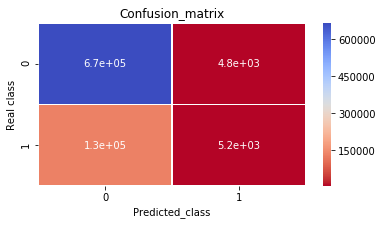


----------Classification Report------------------------------------
             precision    recall  f1-score   support

          0       0.83      0.99      0.91    671406
          1       0.52      0.04      0.07    137174

avg / total       0.78      0.83      0.77    808580



In [128]:
# Predicting the Test set results
log_pred = log.predict(X_test_sc)
model_scores(y_test, log_pred)

#### Use your model to predict values on holdout data

In [129]:
# Generate predictions: predictions
predictions_log = log.predict_proba(X_holdout_sc)

In [131]:
# Predicting the Test set results
log_pred_prob = log.predict_proba(X_test_sc)

The ROC curve represents how the classifier is performing. The x-axis is the false positive rate and the y-axis is the true positive rate or recall. We want the ROC curve to be as close to the upper left hand corner as possible, which shows that we have classified all instances correctly. The area under the curve is the percentage of tradeoff between sensitivity (true positives) and specificity (1-false positives).

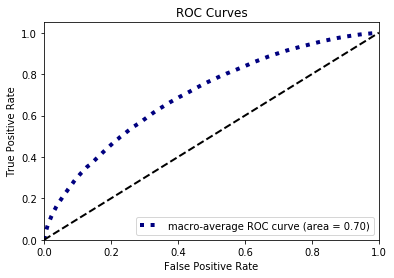

In [132]:
import scikitplot as skplt

#y_true = # ground truth labels
#y_probas = # predicted probabilities generated by sklearn classifier
skplt.metrics.plot_roc_curve(y_test, log_pred_prob, curves='macro')
plt.show()

<a id='4.2'></a>
## Decision Tree

In [133]:
# Import the necessary modules
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
import numpy as np

# Instantiate the classifier: dt_clf_4
dt_clf_4 = DecisionTreeClassifier(max_depth=4)

# Fit the classifier to the training set
dt_clf_4.fit(X_train_sc, y_train)

# Predict the labels of the test set: y_pred_4
y_pred_4 = dt_clf_4.predict(X_test_sc)

# Compute the accuracy of the predictions: accuracy
accuracy = float(np.sum(y_pred_4==y_test))/y_test.shape[0]
print("accuracy:", accuracy)

accuracy: 0.8310754656311063


Accuracy Score: 0.8310754656311063

Average Precision Score: 0.17373024120503386

Average F1 Score: 0.015709560492617226


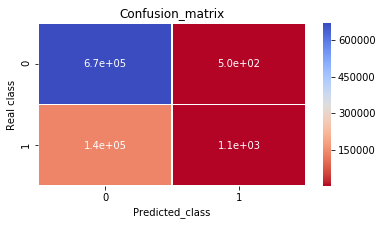


----------Classification Report------------------------------------
             precision    recall  f1-score   support

          0       0.83      1.00      0.91    671406
          1       0.68      0.01      0.02    137174

avg / total       0.81      0.83      0.76    808580



In [134]:
# Predicting the Test set results
dt_pred = dt_clf_4.predict(X_test_sc)
model_scores(y_test, dt_pred)

In [135]:
# Predict the labels of the test set: y_pred_4
y_pred_4_prob = dt_clf_4.predict_proba(X_test_sc)

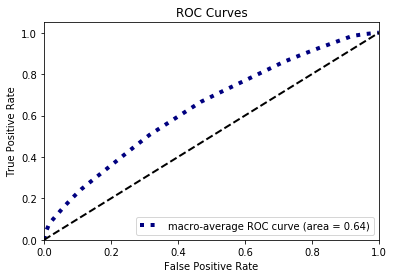

In [136]:
import scikitplot as skplt

#y_true = # ground truth labels
#y_probas = # predicted probabilities generated by sklearn classifier
skplt.metrics.plot_roc_curve(y_test, y_pred_4_prob, curves='macro')
plt.show()

<a id='4.3'></a>
# Random Forest Classifier

Random Forest is an ensemble method that will do both classification and regression. Random forest takes a subsample of the data set using a technique called bootstrapping. What bootstrap does is it keeps the same length of the data but replaces on observation with a random observation from that sample. With this technique you may get multiples of the same observation, but the idea is that you are covering the entire population. From this sample it then generates a set of decisions based on a random sample of features. It decides the threshold of the feature, and makes a split. Each of the trees MSE value is averaged together to output the accuracy.

Random Forest is a part of the CART (Classification and Regression Trees). The tree series stems off the basic idea of a decision tree with rules that split the data into different nodes.

First, the Random Forest will be run without undersample or oversample.  Then it will be run with undersample and oversample.

In [137]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix

In [138]:
#Time permitting, I would have used these params with Randomized Search CV
# rf_params = {
#    'n_estimators' : np.arange(100, 300, 50),
#    'criterion' : ['gini','entropy'],
#    'max_features' : ['auto', 'sqrt', 'log2'],
#    'max_depth': np.arange(1, 10, 1),
#    'min_samples_split' : np.arange(2, 10, 1)
# }

In [139]:
%%time

rf = RandomForestClassifier()
rf_model = rf.fit(X_train_sc, y_train)

winsound.Beep(500,10000)

Wall time: 3min 56s


In [140]:
rf_pred = rf_model.predict(X_test_sc)

In [141]:
# Generate predictions: predictions
predictions_rf = rf_model.predict_proba(X_holdout_sc)

winsound.Beep(500,10000)

In [113]:
#Time permitting, I would used Randomized Search CV

# %%time

# rf = RandomForestClassifier()
# grid_search = GridSearchCV(estimator = rf,
#                             param_grid = rf_params,
#                            scoring = 'accuracy',
#                             cv = 1,
#                             n_jobs = -1)
# rf_grid = GridSearchCV(rf, param_grid=rf_params)
# rf_model = rf_grid.fit(X_train_sc, y_train)

# rf_pred = rf_model.predict(X_test_sc)

# winsound.Beep(500,10000)

Accuracy Score: 0.8324952385663756

Average Precision Score: 0.19144528029836885

Average F1 Score: 0.10054389331987436


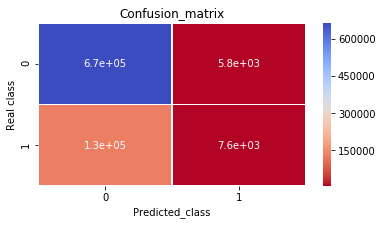


----------Classification Report------------------------------------
             precision    recall  f1-score   support

          0       0.84      0.99      0.91    671406
          1       0.56      0.06      0.10    137174

avg / total       0.79      0.83      0.77    808580



In [142]:
model_scores(y_test, rf_pred)

In [143]:
# Predict the labels of the test set: y_pred_4
y_pred_rf_prob = rf_model.predict_proba(X_test_sc)

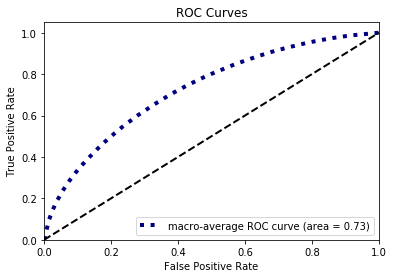

In [144]:
import scikitplot as skplt

#y_true = # ground truth labels
#y_probas = # predicted probabilities generated by sklearn classifier
skplt.metrics.plot_roc_curve(y_test, y_pred_rf_prob, curves='macro')
plt.show()

<a id='4.4'></a>
# XGBoost

'Extreme Gradient Boosting' is another ensemble method that can handle both regression and classification. XGBoost is known for its speed and model performance. New models are added to the original to correct errors made by the original. Gradient boosting creates new models that predict the errors of the previous model and add them together for the final prediction. XGBoost uses gradient descent algorithm to minimize the loss when adding the new models. Gradient Descent is an itterative optimization algorithm that uses learning rate to find the optimal local minimum.

In [69]:
# Create the DMatrix: dmatrix
dmatrix = xgb.DMatrix(data=X_train_sc, label=y_train)

winsound.Beep(500,10000)

In [146]:
# Create the parameter dictionary: params
params = {"objective":"reg:logistic", "max_depth":3}

# Perform cross-validation: cv_results
cv_results = xgb.cv(dtrain=churn_dmatrix, params=params, nfold=3, num_boost_round=5, metrics="auc", as_pandas=True, early_stopping_rounds=True, seed=123)

winsound.Beep(500,10000)

In [147]:
# Print cv_results
print(cv_results)

# Print the AUC
print("\nauc: %f" % ((cv_results["test-auc-mean"]).iloc[-1]))

   test-auc-mean  test-auc-std  train-auc-mean  train-auc-std
0       0.617185      0.000354        0.617185       0.000177
1       0.649586      0.000200        0.649586       0.000111
2       0.652531      0.000246        0.652534       0.000120
3       0.657518      0.000267        0.657517       0.000144
4       0.661988      0.000484        0.662035       0.000134

auc: 0.661988


In [149]:
# Create the DMatrix: churn_dmatrix
churn_dmatrix = xgb.DMatrix(data=X_train_sc, label=y_train)

# Create the parameter dictionary: params
params = {"objective":"reg:logistic", "max_depth":3}

# Perform cross-validation: cv_results
cv_results = xgb.cv(dtrain=churn_dmatrix, params=params, nfold=3, num_boost_round=5, metrics="auc", as_pandas=True, early_stopping_rounds=True, seed=123)

# Print cv_results
print(cv_results)

# Print the AUC
print("\nauc: %f" % ((cv_results["test-auc-mean"]).iloc[-1]))

winsound.Beep(500,10000)

   test-auc-mean  test-auc-std  train-auc-mean  train-auc-std
0       0.617185      0.000354        0.617185       0.000177
1       0.649586      0.000200        0.649586       0.000111
2       0.652531      0.000246        0.652534       0.000120
3       0.657518      0.000267        0.657517       0.000144
4       0.661988      0.000484        0.662035       0.000134

auc: 0.661988


In [150]:
# Instantiate the XGBClassifier: xg_cl
xg_cl = xgb.XGBClassifier(objective='binary:logistic', n_estimators=10, seed=123)

# Fit the classifier to the training set
xg_cl.fit(X_train_sc, y_train)

# Predict the labels of the test set: preds
xgb_preds = xg_cl.predict(X_test_sc)

# Compute the accuracy: accuracy
accuracy = float(np.sum(xgb_preds==y_test))/y_test.shape[0]
print("accuracy: %f" % (accuracy))

winsound.Beep(500,10000)

accuracy: 0.831056


In [71]:
# Create the DMatrix: housing_dmatrix
dmatrix = xgb.DMatrix(data=X_train_sc, label=y_train)

# Create the parameter dictionary: params
params = {"objective":"binary:logistic", "max_depth":4}

# Train the model: xg_reg
xg_reg = xgb.train(params=params, dtrain=dmatrix, num_boost_round=10)

winsound.Beep(500,10000)

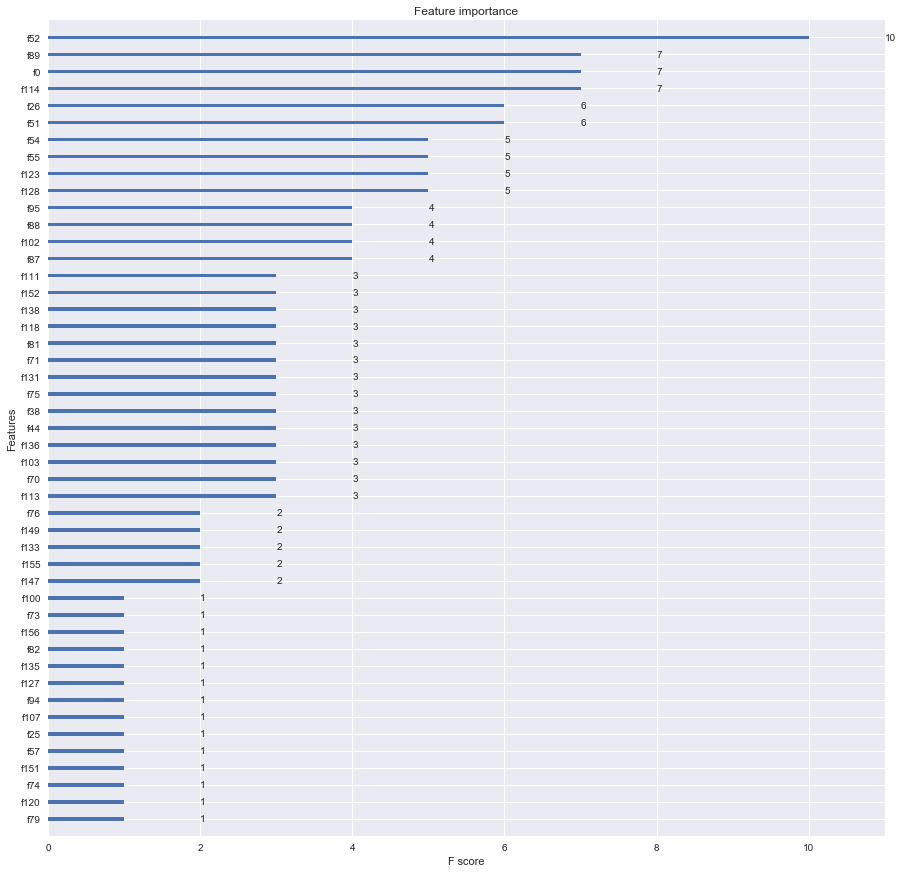

In [86]:
# Plot the feature importances
#plt.subplots(figsize=(12,3))
#xgb.plot_importance(xg_reg)
fig, ax = plt.subplots(figsize=(15, 15))
xgb.plot_importance(xg_reg, ax=ax)
plt.show()

winsound.Beep(500,10000)

Most important features:
    
    1.F52
    2.F89
    3.F0
    4.F114
    5.F26: 

In [147]:
comb_data.columns

Index(['click', 'C1', 'C15', 'C16', 'C17', 'C18', 'C19', 'C21', 'dct_2',
       'dct_3', 'dct_5', 'ac_1', 'ac_2', 'ac_3', 'ac_4', 'ac_5', 'ac_6',
       'ac_7', 'ac_99', 'sc_1', 'sc_2', 'sc_3', 'sc_4', 'sc_5', 'sc_6', 'sc_7',
       'sc_8', 'sc_99'],
      dtype='object')

Accuracy Score: 0.8310556778550051

Average Precision Score: 0.1736939366838118

Average F1 Score: 0.01583539260678804


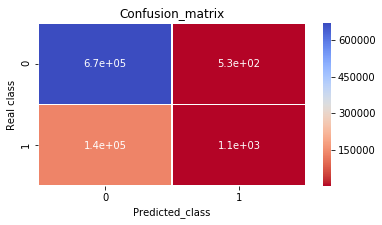


----------Classification Report------------------------------------
             precision    recall  f1-score   support

          0       0.83      1.00      0.91    671406
          1       0.67      0.01      0.02    137174

avg / total       0.80      0.83      0.76    808580



In [152]:
model_scores(y_test, xgb_preds)

In [155]:
# Predict the labels of the test set: y_pred_4
y_pred_xgb_prob = xg_cl.predict_proba(X_test_sc)

winsound.Beep(500,10000)

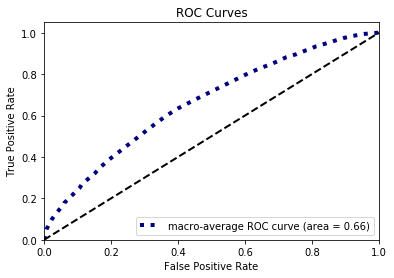

In [156]:
import scikitplot as skplt

#y_true = # ground truth labels
#y_probas = # predicted probabilities generated by sklearn classifier
skplt.metrics.plot_roc_curve(y_test, y_pred_xgb_prob, curves='macro')
plt.show()

winsound.Beep(500,10000)

<a id='5'></a>
## Results:

Of the four models that were used for this analysis: Logistic Regression, Decision Tree, Random Forest, and XGBoost, the best model was Random Forest with an accuracy of .83 and AUC of .72.

| Model: |Logistic Regresion|Decision Tree|Random Forest Classifier|XGBosst|
|--------|------------------|-------------|------------------------|-------|
|Accuracy|        .83       |      .83    |           .83          |  .83  |
|--------|------------------|-------------|------------------------|-------|
|  AUC   |        .70       |      .64    |           .73          |  .66  |